In [68]:
from fish_helpers import *
import time
from functools import partial
from multiprocessing import Pool
import pylab as pl
from IPython import display
import tqdm.notebook as tqdm
import math
import random
import operator
import matplotlib._color_data as mcd
base_path = '/bigstore/GeneralStorage/Zach/MERCI/Autism/'

In [69]:
class GeneClass(object):
    def __init__(self,Gene_Matrix_Avg,Gene_Matrix_std,pos_cells,ngenes=25,keepers=10,
                 neg_cells=[],fold_thresh=2,difference_thresh=5,noise=1,
                 offspring_size=5,mutation_rate_info=[10,100,2],iterations=20,color='r',
                 A=0,verbose=False,base_path='',filter_genes=True,log=True,
                 metric_parameter=-1,display='distance'):
        self.display = display
        self.metric_parameter = metric_parameter
        self.log = log
        self.base_path = base_path
        self.ngenes = ngenes
        self.genes = list(Gene_Matrix_Avg.index)
        self.Gene_Matrix_Avg = Gene_Matrix_Avg
        self.Gene_Matrix_std = Gene_Matrix_std
        self.Gene_Matrix_Avg['blank'] = 0
        self.Gene_Matrix_std['blank'] = 0
        self.pos_cells = pos_cells
        if len(neg_cells)==0:
            self.neg_cells = [i for i in Gene_Matrix_Avg.columns if not i in pos_cells]
        else:
            self.neg_cells = neg_cells
        self.fold_thresh = fold_thresh
        self.difference_thresh = difference_thresh
        if filter_genes:
            self.filter_matrix()
        self.A = A
        for i in range(500): # maybe tune this number
            self.Gene_Matrix_Avg.loc['blank'+str(i)] = self.Gene_Matrix_Avg.iloc[0]*0
            self.Gene_Matrix_std.loc['blank'+str(i)] = self.Gene_Matrix_std.iloc[0]*0
            self.genes.append('blank'+str(i))
        self.keepers = keepers
        self.noise = noise
        self.offspring_size = offspring_size
        self.mutation_rate = mutation_rate_info[0]
        self.mutation_step = mutation_rate_info[1]
        self.mutation_direction = mutation_rate_info[2]
        self.iterations = iterations
        self.verbose = verbose
        self.color = color
        self.pos_df = self.Gene_Matrix_Avg[self.pos_cells]
        self.neg_df = self.Gene_Matrix_Avg[self.neg_cells]
        self.pos_std_df = self.Gene_Matrix_std[self.pos_cells]
        self.neg_std_df = self.Gene_Matrix_std[self.neg_cells]
    
    def filter_matrix(self):
        signal_df = pd.DataFrame(index=self.Gene_Matrix_Avg.index,columns=['Pos','Neg','Pos_std','Neg_std','Difference',
                                                                           'Fold','sq_sum_std','value'])
        if len(self.pos_cells)>1:
            signal_df['Pos'] = np.max(self.Gene_Matrix_Avg[self.pos_cells],axis=1)
            signal_df['Pos_std'] = np.sum(self.Gene_Matrix_std[self.pos_cells],axis=1)
        else:
            signal_df['Pos'] = self.Gene_Matrix_Avg[self.pos_cells]
            signal_df['Pos_std'] = self.Gene_Matrix_std[self.pos_cells]
            
        signal_df['Neg'] = np.average(self.Gene_Matrix_Avg[self.neg_cells],axis=1)
        signal_df['Neg_std'] = np.sum(self.Gene_Matrix_std[self.neg_cells],axis=1)
        signal_df['Difference'] = signal_df['Pos']-signal_df['Neg']
        signal_df['Fold'] = signal_df['Pos']/signal_df['Neg']
        signal_df['sq_sum_std'] = np.sqrt(signal_df['Pos_std']+signal_df['Neg_std'])
        signal_df['value'] = signal_df['Difference']/signal_df['sq_sum_std']
        
        non_zero_genes = signal_df[signal_df['Pos']>0]
        filtered_genes = non_zero_genes[(non_zero_genes['Fold']>self.fold_thresh)&(non_zero_genes['Difference']>self.difference_thresh)]
        
        genes = list(filtered_genes.index)
        if len(genes)<=self.ngenes:
            print('Gene Filtering possibly too stringent')
            print('Only',len(genes),' genes passed')
            print('Thresholds: fold',self.fold_thresh,'diff',self.difference_thresh)
            print('Pos Cells:',self.pos_cells)
            print('Using all non zero genes',len(non_zero_genes.index))
            genes = list(non_zero_genes.index)
        self.genes = genes
        self.Gene_Matrix_Avg = self.Gene_Matrix_Avg.loc[self.genes].sort_index(axis=1)
        self.Gene_Matrix_std = self.Gene_Matrix_std.loc[self.genes].sort_index(axis=1)
    
    def generate_deterministic_start(self):     
        deterministic_population = []
        deterministic_genes = []
        neg_df = np.average(self.neg_df,axis=1)+self.noise
        neg_std_df = np.sum(self.neg_std_df,axis=1)+self.noise
        for cell in self.pos_cells:
            signal_df = pd.DataFrame(index=self.Gene_Matrix_Avg.index,columns=['Pos','Neg','Pos_std','Neg_std','Difference',
                                                                               'Fold','sq_sum_std','value'])
            signal_df['Pos'] = self.Gene_Matrix_Avg[cell]+self.noise
            signal_df['Neg'] = neg_df
            signal_df['Pos_std'] = self.Gene_Matrix_std[cell]+self.noise
            signal_df['Neg_std'] = neg_std_df
            signal_df['Difference'] = signal_df['Pos']-neg_df
            signal_df['Fold'] = signal_df['Pos']/neg_df
            signal_df = signal_df[signal_df['Pos']>self.noise]
            signal_df = signal_df[(signal_df['Fold']>self.fold_thresh)&(signal_df['Difference']>self.difference_thresh)]
            signal_df['sq_sum_std'] = np.sqrt(signal_df['Pos_std']+neg_std_df)
            signal_df['value'] = signal_df['Difference']/signal_df['sq_sum_std']
            deterministic_genes.extend(list(signal_df.sort_values('value',ascending=False)[:self.ngenes].index))
        deterministic_genes = list(np.unique(deterministic_genes))
        
        start = time.time()
        if len(deterministic_genes)<(self.ngenes):
            print('pos cells:',self.pos_cells)
            print('deterministic gene filtering may be too stringent')
            print('wanted:',(self.ngenes),'genes got:',len(deterministic_genes),'genes')
            print('appending with random genes')
            while len(deterministic_genes)<(self.ngenes):
                gene = random.sample(self.genes,1)[0]
                if not gene in deterministic_genes:
                    deterministic_genes.append(gene)
                deterministic_genes = list(np.unique(deterministic_genes))
                if time.time()-start>5:
                    print('took too long to append genes to deterministic',len(deterministic_genes),self.ngenes)
                    raise NameError('generate_deterministic_start genes Failed')
        self.deterministic_genes = deterministic_genes
        for i in range(self.keepers):
            deterministic_population.append(random.sample(deterministic_genes,self.ngenes))
            self.survivors = deterministic_population

    def generate_offspring(self):
        offspring = []
        for species in self.survivors:
            for i in range(self.offspring_size):
                mate = random.sample(self.survivors,1)[0]
                mix = list(np.unique(list(mate)+list(species)))
                start = time.time()
                while len(mix)<self.ngenes:
                    gene = random.sample(self.genes,1)[0]
                    if not gene in mix:
                        mix.append(gene)
                    if time.time()-start>5:
                        print('took too long to make mix >= ngenes',len(mix),self.ngenes)
                        raise ValueError('generate_offspring Failed')
                offspring.append(random.sample(mix,self.ngenes))
        self.offspring = offspring
        self.progenerators = self.survivors+self.offspring

    def generate_mutations(self):
        mutations = []
        for species in self.progenerators:
            mutant = list(np.unique(species))
            nkeepers = int(self.ngenes - random.randint(0,self.mutation_rate))
            if nkeepers<1:
                mutant = []
            elif nkeepers>len(mutant):
                continue
            else:
                mutant = random.sample(mutant,nkeepers)
            start = time.time()
            while len(mutant)<self.ngenes:
                gene = random.sample(self.genes,1)[0]
                if not gene in mutant:
                    mutant.append(gene)
                if time.time()-start>5:
                    print('took too long to find gene to mutate',gene)
                    print(self.pos_cells)
                    print('len genes',len(self.genes),self.ngenes,len(mutant))
                    raise ValueError('generate_mutations Failed')
            mutations.append(mutant)
        self.mutations = mutations
        self.population = self.mutations+self.progenerators

    def populate(self):
        mutation_rate = int(self.mutation_rate*self.ngenes)
        if len(self.survivors)!=self.keepers:
            self.generate_deterministic_start()
        self.generate_offspring()
        self.generate_mutations()
        for i in range(len(self.survivors)):
            self.population.append(random.sample(self.deterministic_genes,self.ngenes))

    def weight_metric(self,metrics):
        sort = np.sort(metrics)
        weights = [(i+1)**(self.metric_parameter) for i in range(len(sort))]
        weights = [i/np.sum(weights) for i in weights]
        metric = np.sum(sort*weights)
        return metric
            
    def calculate_metric(self,species):
        non_blanks = len([i for i in species if not 'blank' in i])
        pos = np.sum(self.pos_df.loc[species],axis=0)
        neg = np.sum(self.neg_df.loc[species],axis=0)
        pos_std = np.sqrt(np.sum(self.pos_std_df.loc[species],axis=0))
        neg_std = np.sqrt(np.sum(self.neg_std_df.loc[species],axis=0))
        metrics = []
        distances = []
        for i,p in enumerate(pos):
            pos_metrics = []
            for j,n in enumerate(neg):
                metric = ((p-n)/(pos_std[i]+neg_std[j]))-(self.A*non_blanks/self.ngenes)
                pos_metrics.append(metric)
                distances.append(p-n)
            metrics.append(self.weight_metric(pos_metrics))
        metric = self.weight_metric(metrics)
        distance = np.average(distances)
        return metric,distance
    
    def selection(self):
        metrics = []
        distances = []
        for species in self.population:
            m,d = self.calculate_metric(species)
            metrics.append(m)
            distances.append(d)
        df = pd.DataFrame(index=range(len(self.population)),columns=['population','metrics','distances'])
        df['population'] = self.population
        df['metrics'] = metrics
        df['distances'] = distances
        df = df.sort_values('metrics',ascending=False)
        survivors = df.iloc[:self.keepers]
        self.survivors = list(survivors['population'])
        self.metrics = list(survivors['metrics'])
        self.distances = list(survivors['distances'])
        self.elite_survivor = self.survivors[0]
        
    def evolve(self,survivors=[]):
        self.X = []
        self.Y = []
        self.max = []
        self.min = []
        self.survivors = survivors
        start_time = time.time()
        for I in range(self.iterations):
            if I%self.mutation_step==0:
                if I!=0:
                    self.mutation_rate= int(self.mutation_rate/self.mutation_direction)
                    if self.mutation_rate<5:
                        self.mutation_rate = 5
            self.populate()
            self.selection()
            if self.display == 'distance':
                avg = np.max(self.distances)
                std = np.std(self.distances)
            elif self.display == 'metric':
                avg = np.max(self.metrics)
                std = np.std(self.metrics) 
            self.X.append(time.time()-start_time)
            self.Y.append(avg)
            self.max.append(avg+std)
            self.min.append(avg-std)
            if self.verbose:
                if self.log:
                    pl.plot(np.log10(self.X),np.log10(self.Y),c='k',linewidth=1)
                    pl.fill_between(np.log10(self.X),np.log10(self.max),np.log10(self.min),color=self.color)
                    pl.ylabel(str('Log10 Average '+self.display))
                    pl.xlabel('Time Log10(s)')
                else:
                    pl.plot(self.X,self.Y,c='k',linewidth=1)
                    pl.fill_between(self.X,self.max,self.min,color=self.color)
                    pl.ylabel(str('Average '+self.display))
                    pl.xlabel('Time(s)')
                display.clear_output(wait=True)
                display.display(pl.gcf())
            if I>10:
                if np.average(self.Y[-5:])==self.Y[-1]:
                    break
            if time.time()-start_time>(60*5):
                break
        if self.verbose:
            display.clear_output(wait=True)

In [70]:
class CodebookClass(object):
    def __init__(self,Gene_Matrix_Avg,Gene_Matrix_std,base_path='',nbits=6,keepers=10,hamming=2,positive_bits=3,
                 ngenes=25, gene_keepers=10,gene_fold_thresh=2,gene_difference_thresh=5,gene_noise=1,
                 gene_offspring_size=10,gene_mutation_rate_info=[30,5,0.5],gene_iterations=20,gene_A=0,gene_verbose=False,
                 substitution_rate=0,swap_rate=0,mutation_rate=5,offspring_rate=10,color='r',ncpu=1,iterations=10,
                 verbose=True,fresh=True,filter_genes=True,log=True,metric_parameter=-1,gene_metric_parameter=-1,
                 gene_display='distance',display='distance'):
        self.gene_display = gene_display
        self.display = display
        self.metric_parameter = metric_parameter
        self.gene_metric_parameter = gene_metric_parameter
        self.log = log
        self.filter_genes = filter_genes
        self.genes = list(Gene_Matrix_Avg.index)
        self.Gene_Matrix_Avg = Gene_Matrix_Avg
        self.Gene_Matrix_std = Gene_Matrix_std
        if 'blank' in Gene_Matrix_Avg.columns:
            self.cells = list(self.Gene_Matrix_Avg.drop(columns='blank').columns)
        else:
            self.cells = list(self.Gene_Matrix_Avg.columns)
        if base_path == '':
            base_path = os.path.join(os.getcwd(),'Results')
        if not os.path.exists(base_path):
            os.mkdir(base_path)
        self.base_path = base_path
        self.nbits = nbits
        self.keepers = keepers
        self.hamming = hamming
        self.positive_bits = positive_bits
        self.ncells = len(self.cells)
        self.ngenes = ngenes
        self.gene_keepers = gene_keepers
        self.gene_fold_thresh = gene_fold_thresh
        self.gene_difference_thresh = gene_difference_thresh
        self.gene_noise = gene_noise
        self.gene_offspring_size = gene_offspring_size
        self.gene_mutation_rate_info = gene_mutation_rate_info
        self.gene_iterations = gene_iterations
        self.gene_A = gene_A
        self.gene_verbose = gene_verbose
        self.substitution_rate = substitution_rate
        self.swap_rate = swap_rate
        self.mutation_rate = mutation_rate
        self.offspring_rate = offspring_rate
        self.color = color
        self.ncpu = ncpu
        self.iterations = iterations
        self.verbose = verbose
        self.fresh = fresh
        
    def generate_deterministic_start(self):
        ne = operator.ne
        best_candidates = []
        while len(best_candidates)<self.ncells:
            best_candidates = []
            very_last_time = time.time()
            base_str = str(''.join('1' for i in range(self.positive_bits)))+str(''.join('0' for i in range(self.nbits-self.positive_bits)))
            while time.time()-very_last_time<10:
                candidates = []
                bad_candidates = []
                last_time = time.time()
                while time.time()-last_time<0.5:
                    candidate = ''.join(random.sample(base_str,len(base_str)))
                    if candidate in candidates:
                        continue
                    elif candidate in bad_candidates:
                        continue
                    good = 0
                    for can in candidates:
                            if sum(map(ne, can, candidate)) < self.hamming:
                                good+=1
                                bad_candidates.append(candidate)
                                break
                    if good==0:
                        candidates.append(candidate)
                        last_time = time.time()
                if len(candidates)>len(best_candidates):
                    best_candidates = candidates
                    very_last_time = time.time()
            if len(best_candidates)<self.ncells:
                print(self.nbits,'bits are not enough for this encoding scheme')
            self.nbits+=1
        codewords_array = np.zeros([len(best_candidates),len(best_candidates[0])])
        for y,cword in enumerate(best_candidates):
            for x,bit in enumerate(cword):
                codewords_array[y,x] = int(bit)
        self.codewords = pd.DataFrame(codewords_array)
        survivors = []
        for k in range(self.keepers):
            species = random.sample(list(self.codewords.index),self.ncells)
            codebook = self.codewords.loc[species].copy()
            codebook.index=random.sample(self.cells,self.ncells)
            codebook.loc['blank'] = codebook.iloc[0]*0
            codebook = codebook.sort_index()
            survivors.append(codebook)
        self.survivors = survivors

    def generate_readout(self,codebook):
        colors = ['r','g','b','c','y','m']
        readout = codebook.copy()
        readout_std = codebook.copy()
        bits = random.sample(list(codebook.columns),len(codebook.columns))
        for bit in bits:
            pos_cells = list(codebook[codebook[bit]==1].index)
            neg_cells = list(codebook[codebook[bit]!=1].index)
            if len(pos_cells)==0:
                readout[bit] = 0
                readout_std[bit] = 0
                continue
            base = ''.join(i+'_' for i in sorted(pos_cells))
            not_completed = True
            temp_base_path = os.path.join(self.base_path,base)
            if not self.fresh:
                if os.path.exists(temp_base_path):
                    if os.path.exists(os.path.join(temp_base_path,'Gene_class.pkl')):
                        if os.path.exists(os.path.join(temp_base_path,'signal.pkl')):
                            if os.path.exists(os.path.join(temp_base_path,'signal_std.pkl')):
                                readout[bit] = pickle.load(open(os.path.join(temp_base_path,'signal.pkl'),'rb'))
                                readout_std[bit] = pickle.load(open(os.path.join(temp_base_path,'signal_std.pkl'),'rb'))
                                not_completed = False
            if not_completed:
                Gene_class = GeneClass(self.Gene_Matrix_Avg,self.Gene_Matrix_std,pos_cells,neg_cells=neg_cells,
                                       ngenes=self.ngenes,keepers=self.gene_keepers,fold_thresh=self.gene_fold_thresh,
                                       difference_thresh=self.gene_difference_thresh,noise=self.gene_noise,offspring_size=self.gene_offspring_size,
                                       mutation_rate_info=self.gene_mutation_rate_info,iterations=self.gene_iterations,
                                       color=self.color,A=self.gene_A,verbose=self.gene_verbose,filter_genes=self.filter_genes,
                                       log=self.log,metric_parameter=self.gene_metric_parameter,display=self.gene_display)
                Gene_class.evolve()
                base = ''.join(i+'_' for i in sorted(pos_cells))
                species = [g for g in Gene_class.elite_survivor if not 'blank' in g]
                signal = np.sum(self.Gene_Matrix_Avg.loc[species],axis=0)
                signal_std = np.sum(self.Gene_Matrix_std.loc[species],axis=0)
                
                if not os.path.exists(temp_base_path):
                    os.mkdir(temp_base_path)
                pd.Series(Gene_class.elite_survivor).to_csv(os.path.join(temp_base_path,'genes.csv'),index=False)
                pickle.dump(Gene_class,open(os.path.join(temp_base_path,'Gene_class.pkl'),'wb'))
                pickle.dump(signal,open(os.path.join(temp_base_path,'signal.pkl'),'wb'))
                pickle.dump(signal_std,open(os.path.join(temp_base_path,'signal_std.pkl'),'wb'))
                
                readout[bit] = signal
                readout_std[bit] = signal_std
        return readout,readout_std

    def weight_metric(self,metrics):
        sort = np.sort(metrics)
        weights = [(i+1)**(self.metric_parameter) for i in range(len(sort))]
        weights = [i/np.sum(weights) for i in weights]
        metric = np.sum(sort*weights)
        return metric
    
    def calculate_metric(self,Readout_df,Readout_std_df):
        distances = []
        metrics = []
        for x,a in enumerate(Readout_df.index):
            pos_metrics = []
            for y,b in enumerate(Readout_df.index):
                if x!=y:
                    dist = np.linalg.norm(np.array(Readout_df.loc[a])-np.array(Readout_df.loc[b]))
                    sep = dist/np.sqrt(np.sum(Readout_std_df.loc[a])+np.sum(Readout_std_df.loc[b])) # Term for num negative bits
                    distances.append(dist)
                    pos_metrics.append(sep)
            metrics.append(self.weight_metric(pos_metrics))
        metric = self.weight_metric(metrics)
        distance = np.average(distances)
        return metric,distance

    def substitute_codewords(self,codebook):
        substituted_codebook = codebook.copy()
        for i in range(random.randint(0,self.substitution_rate)):
            substituted_codebook.loc[random.sample(self.cells,1)[0]] = substituted_codebook.sample(n=1,axis=0).iloc[0].copy()
        return substituted_codebook

    def swap_codewords(self,codebook):
        swap_codebook = codebook.copy()
        for i in range(random.randint(0,self.swap_rate)):
            a = random.sample(self.cells,1)[0]
            b = random.sample(self.cells,1)[0]
            A = swap_codebook.loc[a].copy()
            B = swap_codebook.loc[b].copy()
            swap_codebook.loc[a] = B
            swap_codebook.loc[b] = A
        return swap_codebook
    
    def mutate_codebook(self,codebook):
        mutated_codebook = codebook.copy()
        for i in range(random.randint(0,self.mutation_rate)):
            rbit = random.sample(list(mutated_codebook.columns),1)[0]
            rcell = random.sample(self.cells,1)[0]
            if mutated_codebook[rbit].loc[rcell]==1:
                mutated_codebook[rbit].loc[rcell] = 0
            else:
                mutated_codebook[rbit].loc[rcell] = 1
        return mutated_codebook

    def populate(self):
        offspring = []
        for codebook in self.survivors:
            for i in range(self.offspring_rate):
                offspring_codebook = codebook.copy()
                offspring_codebook = self.substitute_codewords(offspring_codebook)
                offspring_codebook = self.swap_codewords(offspring_codebook)
                offspring_codebook = self.mutate_codebook(offspring_codebook)
                offspring_codebook.loc['blank'] = offspring_codebook.iloc[0]*0
                offspring.append(offspring_codebook)
        self.offspring = offspring
        self.population = self.survivors+self.offspring

    def wrapper(self,codebook):
        readout,readout_std = self.generate_readout(codebook)
        metric,distance = self.calculate_metric(readout,readout_std)
        return codebook,readout,readout_std,metric,distance
        
    def selection(self):
        distances = []
        metrics = []
        readouts = []
        readout_stds = []
        new_population =[]
        if self.ncpu==1:
            for codebook in tqdm.tqdm(self.population):
                codebook,readout,readout_std,metric,distance = self.wrapper(codebook)
                readouts.append(readout)
                readout_stds.append(readout_std)
                metrics.append(metric)
                distances.append(distance)
                new_population.append(codebook)
        else:
            sys.stdout.flush()
            with Pool(self.ncpu) as p:
                for codebook,readout,readout_std,metric,distance in tqdm.tqdm(p.imap(self.wrapper,self.population,chunksize=1),total=len(self.population)):
                    readouts.append(readout)
                    readout_stds.append(readout_std)
                    metrics.append(metric)
                    distances.append(distance)
                    new_population.append(codebook)
            sys.stdout.flush()
        df = pd.DataFrame(index=range(len(self.population)),columns=['population','distances','metrics','readouts','readout_stds'])
        df['population'] = new_population
        df['distances'] = distances
        df['metrics'] = metrics
        df['readouts'] = readouts
        df['readout_stds'] = readout_stds
        df = df.sort_values('metrics',ascending=False)
        survivors = df.iloc[:self.keepers]
        self.distances = list(survivors['distances'])
        self.metrics = list(survivors['metrics'])
        self.survivors = list(survivors['population'])
        self.readouts = list(survivors['readouts'])
        self.readout_stds = list(survivors['readout_stds'])
        self.elite_survivor = self.survivors[0]
        
    def evolve(self):
        self.X = []
        self.Y = []
        self.max = []
        self.min = []
        self.generate_deterministic_start()
        save_path = ''
        i=1
        while save_path=='':
            temp = os.path.join(self.base_path,'Results_'+str(i))
            if os.path.exists(temp):
                i+=1
            else:
                save_path = temp
                os.makedirs(save_path)
        self.save_path = save_path
        start_time = time.time()
        for I in range(self.iterations):
            if self.verbose:
                print('Iteration ',I)
            pickle.dump(self.__dict__,open(os.path.join(self.save_path,str('CodebookClass_values_'+str(I)+'.pkl')),'wb'))
            self.populate()
            self.selection()
            if self.display == 'distance':
                avg = np.max(self.distances)
                std = np.std(self.distances)
            elif self.display == 'metric':
                avg = np.max(self.metrics)
                std = np.std(self.metrics)
            self.X.append(time.time()-start_time)
            self.Y.append(avg)
            self.max.append(avg+std)
            self.min.append(avg-std)
            pickle.dump(self.__dict__,open(os.path.join(self.save_path,str('CodebookClass_values_'+str(I)+'.pkl')),'wb'))
            pickle.dump(self.elite_survivor,open(os.path.join(self.save_path,str('elite_survivor_'+str(I)+'.pkl')),'wb'))
            pickle.dump(self.survivors,open(os.path.join(self.save_path,str('survivors_'+str(I)+'.pkl')),'wb'))
            pickle.dump(self.readouts,open(os.path.join(self.save_path,str('readouts_'+str(I)+'.pkl')),'wb'))
            pickle.dump(self.readout_stds,open(os.path.join(self.save_path,str('readout_stds_'+str(I)+'.pkl')),'wb'))
            if self.verbose:
                if self.log:
                    pl.plot(np.log10(self.X),np.log10(self.Y),c='k',linewidth=1)
                    pl.fill_between(np.log10(self.X),np.log10(self.max),np.log10(self.min),color=self.color)
                    pl.ylabel(str('Log10 Average '+self.display))
                    pl.xlabel('Time Log10(s)')
                else:
                    pl.plot(self.X,self.Y,c='k',linewidth=1)
                    pl.fill_between(self.X,self.max,self.min,color=self.color)
                    pl.ylabel(str('Average '+self.display))
                    pl.xlabel('Time(s)')
                display.clear_output(wait=True)
                display.display(pl.gcf())
            if I>10:
                if np.average(self.Y[-5:])==self.Y[-1]:
                    break
#             if time.time()-start_time>(60*5):
#                 break
        if self.verbose:
            display.clear_output(wait=True)

In [52]:
def test_gene_picking(pos_cells,
                      Gene_Matrix_Avg,
                      Gene_Matrix_std,
                      codebook_df,
                      ngenes=50, 
                      gene_keepers=10,
                      gene_fold_thresh=1,
                      gene_difference_thresh=10,
                      gene_noise=1,
                      gene_offspring_size=3,
                      gene_mutation_rate_info=[30,100,1],
                      gene_iterations=200,
                      gene_A=0,
                      gene_verbose=True,
                      filter_genes=False,
                      gene_metric_parameter=-1,
                      gene_display='distance',
                      log=True):
    color = random.sample(list(mcd.CSS4_COLORS.keys()),1)
    c = []
    for i in codebook_df.index:
        if i in pos_cells:
            c.append(1)
        else:
            c.append(0)
    neg_cells = [i for i in Gene_Matrix_Avg.columns if not i in pos_cells]
    Gene_class = GeneClass(Gene_Matrix_Avg,Gene_Matrix_std,pos_cells,neg_cells=neg_cells,
       ngenes=ngenes,keepers=gene_keepers,fold_thresh=gene_fold_thresh,
       difference_thresh=gene_difference_thresh,noise=gene_noise,offspring_size=gene_offspring_size,
       mutation_rate_info=gene_mutation_rate_info,iterations=gene_iterations,
       color=color,A=gene_A,verbose=gene_verbose,filter_genes=filter_genes,
       log=log,metric_parameter=gene_metric_parameter,display=gene_display)
    Gene_class.evolve()
    species = [g for g in Gene_class.elite_survivor if not 'blank' in g]
    signal = np.sum(Gene_Matrix_Avg.loc[species],axis=0)
    signal_std = np.sum(Gene_Matrix_std.loc[species],axis=0)
    genes = Gene_class.elite_survivor
    return c,signal,signal_std,genes


In [61]:
def gene_tester(pfunc,base_path='/bigstore/GeneralStorage/Zach/MERCI/Autism/',ncpu=30):
    Gene_Matrix_Avg = pickle.load(open(os.path.join(base_path,'Gene_Matrix_Avg_Neuron_SizeNorm.pkl'),'rb'))
    Gene_Matrix_std = pickle.load(open(os.path.join(base_path,'Gene_Matrix_std_Neuron_SizeNorm.pkl'),'rb'))
    signal_df = pd.DataFrame(index=Gene_Matrix_Avg.columns)
    codebook_df = pd.DataFrame(index=Gene_Matrix_Avg.columns)
    signal_std_df = pd.DataFrame(index=Gene_Matrix_Avg.columns)
    pos_cells = random.sample(list(Gene_Matrix_Avg.columns),4)
    Input = []
    for i in range(ncpu):
        Input.append(pos_cells)
    #     Input.append(random.sample(list(self.Gene_Matrix_Avg.columns),4))
    sys.stdout.flush()
    out_genes = []
    with Pool(ncpu) as p:
        i=0
        for c,signal,signal_std,genes in tqdm.tqdm(p.imap(pfunc,Input,chunksize=1),total=len(Input)):
            signal_df[i] = signal
            codebook_df[i] = c
            signal_std_df[i] = signal_std
            out_genes.append(genes)
            i+=1
    sys.stdout.flush()
    fig, axes = plt.subplots(ncols=4, figsize=(15, 8))
    ax1,ax2,ax3,ax4 = axes
    norm_df = signal_df.copy()
    norm_df = norm_df-np.min(norm_df,axis=0)
    norm_df = norm_df/np.max(norm_df,axis=0)
    im1 = sns.heatmap(norm_df,cmap='inferno',ax=ax1,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=True)
    im2 = sns.heatmap(signal_df,cmap='inferno',ax=ax2,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
    im3 = sns.heatmap(signal_std_df,cmap='inferno',ax=ax4,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
    im4 = sns.heatmap(codebook_df,cmap='inferno',ax=ax3,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
    plt.show()
    data = signal_df.T
    data = data.melt(var_name='cells',value_name='signal')
    print(pos_cells)
    plt.figure(figsize=[15,4])
    sns.violinplot(data=data,x='cells',y='signal')
    plt.show()
    plt.figure(figsize=[15,3])
    species = out_genes[0]
    signal = np.sum(Gene_Matrix_Avg.loc[species],axis=0)
    signal = signal/np.max(signal)
    plt.bar(signal.index,list(signal),color='r',alpha=0.5)
    plt.bar(codebook_df[0].index,list(codebook_df[0]),color='k',alpha=0.5)
    plt.show()

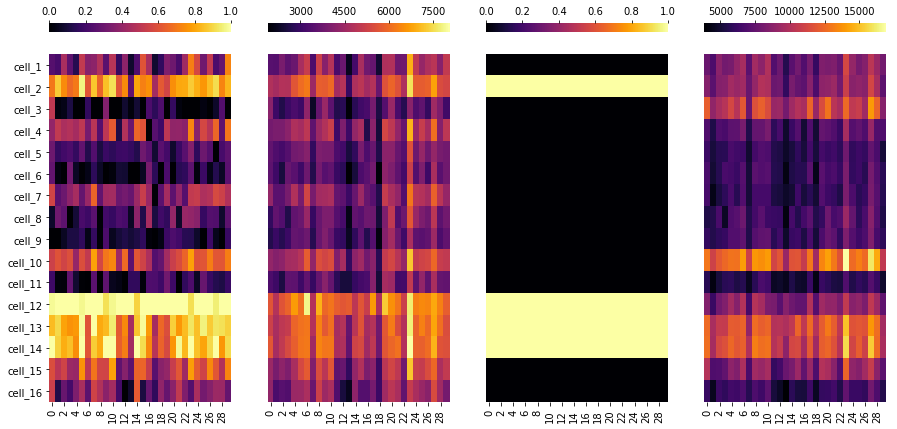

['cell_13', 'cell_2', 'cell_14', 'cell_12']


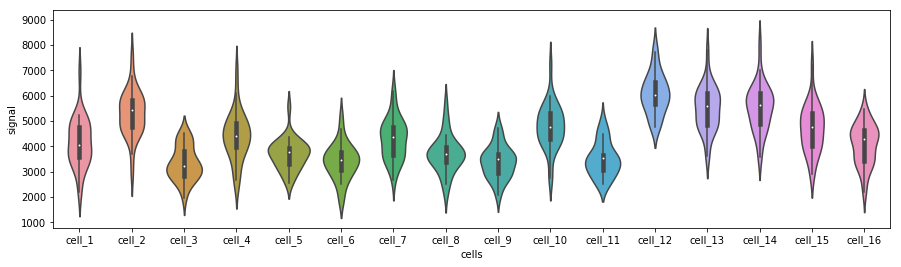

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


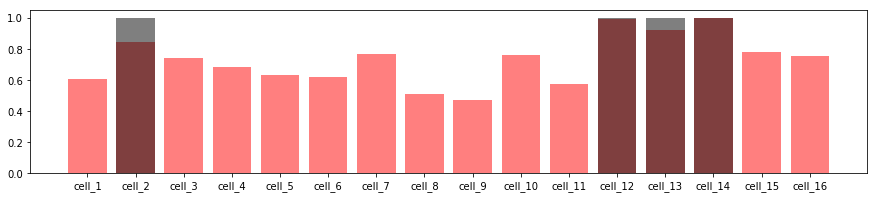

In [51]:
Gene_Matrix_Avg = pickle.load(open(os.path.join(base_path,'Gene_Matrix_Avg_Neuron_SizeNorm.pkl'),'rb'))
Gene_Matrix_std = pickle.load(open(os.path.join(base_path,'Gene_Matrix_std_Neuron_SizeNorm.pkl'),'rb'))
codebook_df = pd.DataFrame(index=Gene_Matrix_Avg.columns)
pfunc = partial(test_gene_picking,
                Gene_Matrix_Avg=Gene_Matrix_Avg,
                Gene_Matrix_std=Gene_Matrix_std,
                codebook_df=codebook_df,
                ngenes=50, 
                gene_keepers=10,
                gene_fold_thresh=1,
                gene_difference_thresh=10,
                gene_noise=1,
                gene_offspring_size=3,
                gene_mutation_rate_info=[30,100,1],
                gene_iterations=200,
                gene_A=0,
                gene_verbose=False,
                filter_genes=False,
                gene_metric_parameter=-1,
                gene_display='distance',
                log=True)
gene_tester(pfunc)

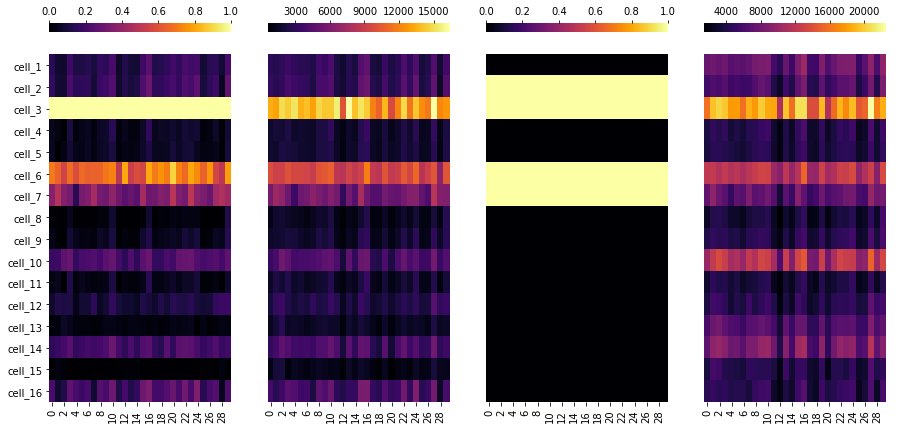

['cell_7', 'cell_2', 'cell_6', 'cell_3']


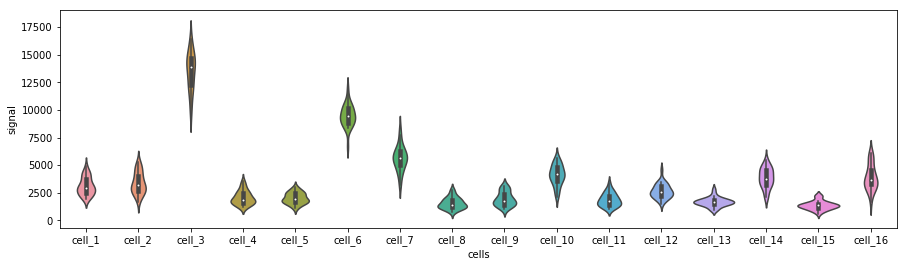

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:60: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


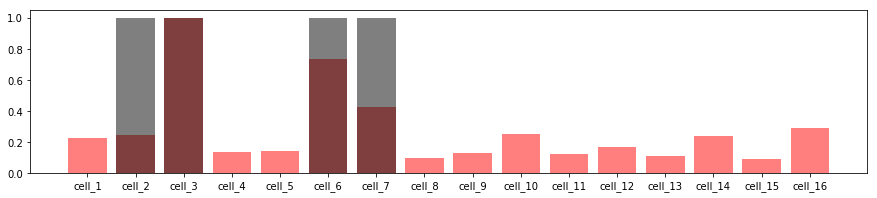

In [53]:
Gene_Matrix_Avg = pickle.load(open(os.path.join(base_path,'Gene_Matrix_Avg_Neuron_SizeNorm.pkl'),'rb'))
Gene_Matrix_std = pickle.load(open(os.path.join(base_path,'Gene_Matrix_std_Neuron_SizeNorm.pkl'),'rb'))
codebook_df = pd.DataFrame(index=Gene_Matrix_Avg.columns)
pfunc = partial(test_gene_picking,
                Gene_Matrix_Avg=Gene_Matrix_Avg,
                Gene_Matrix_std=Gene_Matrix_std,
                codebook_df=codebook_df,
                ngenes=50, 
                gene_keepers=10,
                gene_fold_thresh=1,
                gene_difference_thresh=10,
                gene_noise=1,
                gene_offspring_size=3,
                gene_mutation_rate_info=[30,100,1],
                gene_iterations=200,
                gene_A=0,
                gene_verbose=False,
                filter_genes=False,
                gene_metric_parameter=0,
                gene_display='distance',
                log=True)
gene_tester(pfunc)

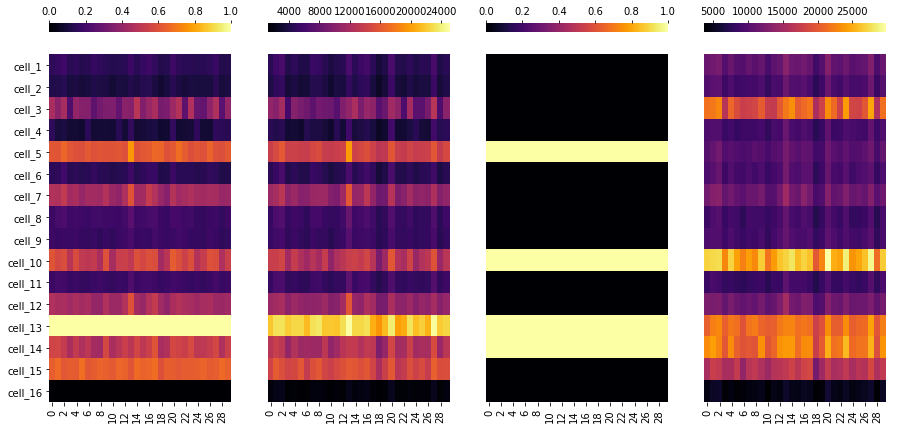

['cell_5', 'cell_10', 'cell_13', 'cell_14']


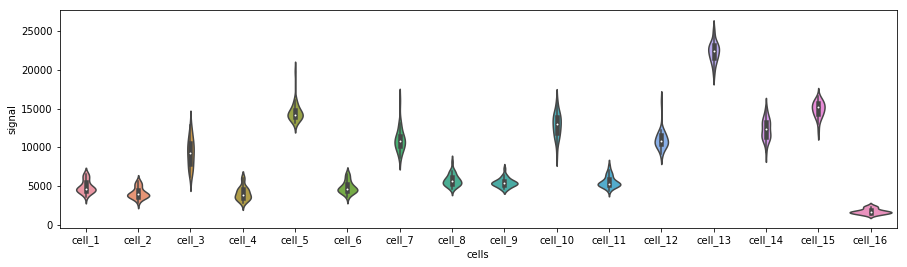

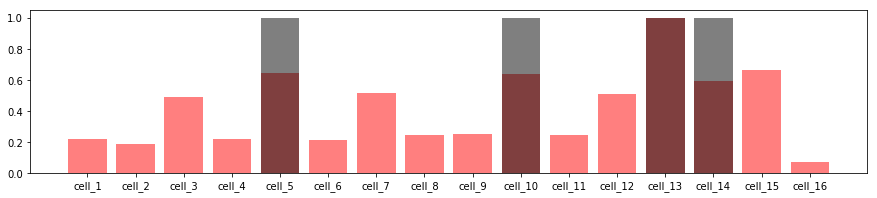

In [55]:
Gene_Matrix_Avg = pickle.load(open(os.path.join(base_path,'Gene_Matrix_Avg_Neuron_SizeNorm.pkl'),'rb'))
Gene_Matrix_std = pickle.load(open(os.path.join(base_path,'Gene_Matrix_std_Neuron_SizeNorm.pkl'),'rb'))
codebook_df = pd.DataFrame(index=Gene_Matrix_Avg.columns)
pfunc = partial(test_gene_picking,
                Gene_Matrix_Avg=Gene_Matrix_Avg,
                Gene_Matrix_std=Gene_Matrix_std,
                codebook_df=codebook_df,
                ngenes=50, 
                gene_keepers=10,
                gene_fold_thresh=1,
                gene_difference_thresh=10,
                gene_noise=1,
                gene_offspring_size=3,
                gene_mutation_rate_info=[30,100,1],
                gene_iterations=200,
                gene_A=0,
                gene_verbose=False,
                filter_genes=False,
                gene_metric_parameter=-0.5,
                gene_display='distance',
                log=True)
gene_tester(pfunc)

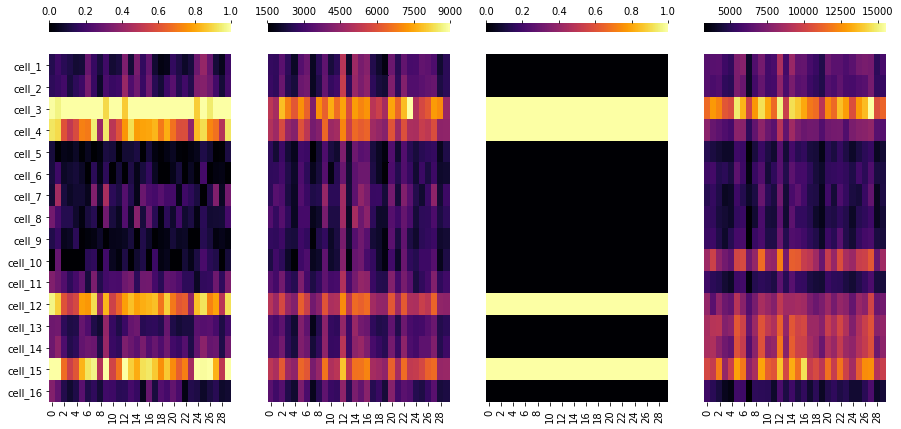

['cell_3', 'cell_12', 'cell_4', 'cell_15']


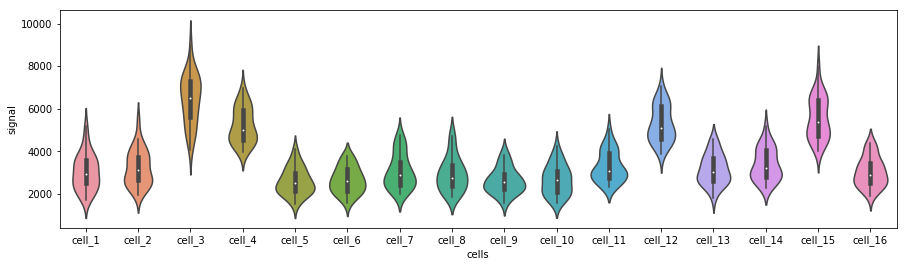

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:67: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


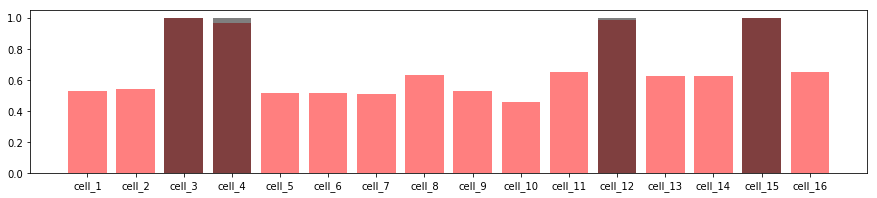

In [60]:
Gene_Matrix_Avg = pickle.load(open(os.path.join(base_path,'Gene_Matrix_Avg_Neuron_SizeNorm.pkl'),'rb'))
Gene_Matrix_std = pickle.load(open(os.path.join(base_path,'Gene_Matrix_std_Neuron_SizeNorm.pkl'),'rb'))
codebook_df = pd.DataFrame(index=Gene_Matrix_Avg.columns)
pfunc = partial(test_gene_picking,
                Gene_Matrix_Avg=Gene_Matrix_Avg,
                Gene_Matrix_std=Gene_Matrix_std,
                codebook_df=codebook_df,
                ngenes=50, 
                gene_keepers=10,
                gene_fold_thresh=1,
                gene_difference_thresh=10,
                gene_noise=1,
                gene_offspring_size=3,
                gene_mutation_rate_info=[30,100,1],
                gene_iterations=200,
                gene_A=0,
                gene_verbose=False,
                filter_genes=False,
                gene_metric_parameter=-3,
                gene_display='distance',
                log=True)
gene_tester(pfunc)

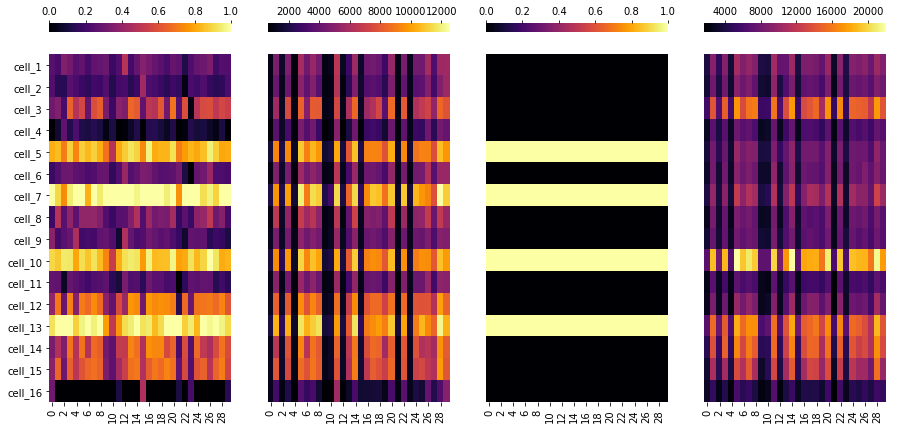

['cell_5', 'cell_13', 'cell_10', 'cell_7']


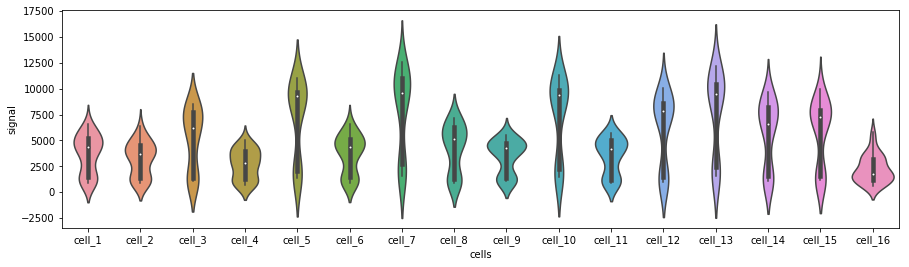

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:41: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


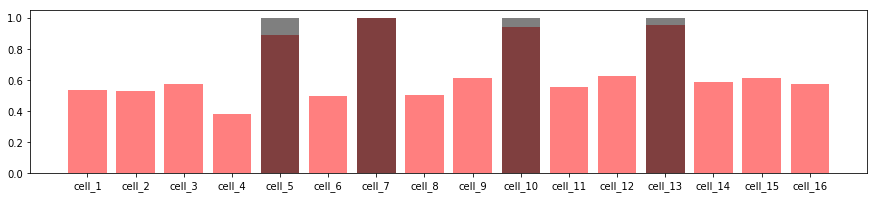

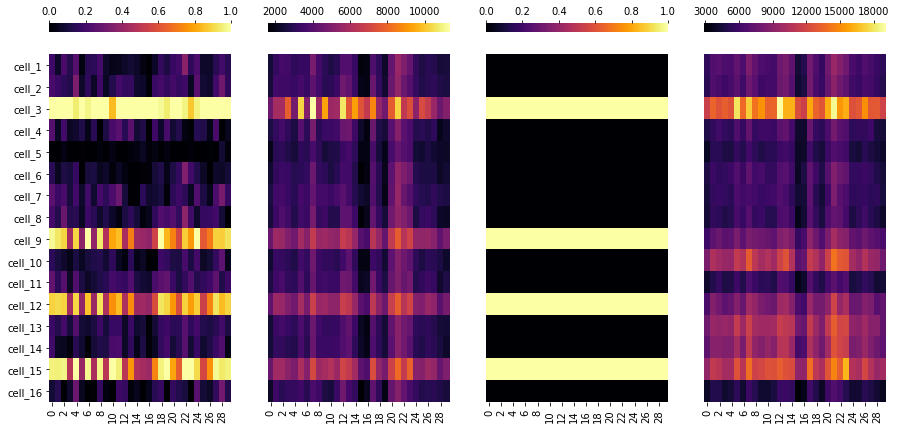

['cell_12', 'cell_3', 'cell_9', 'cell_15']


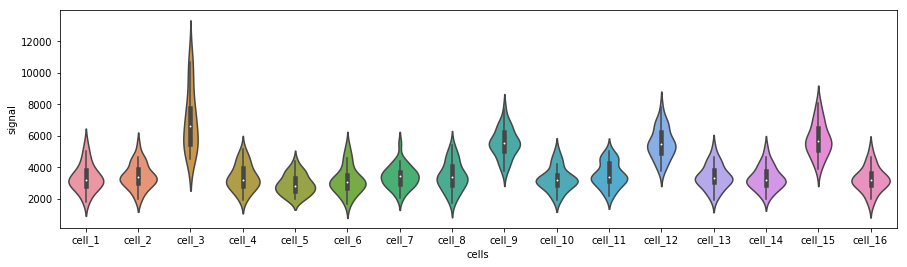

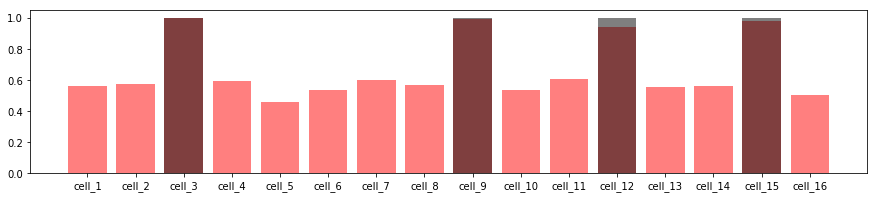

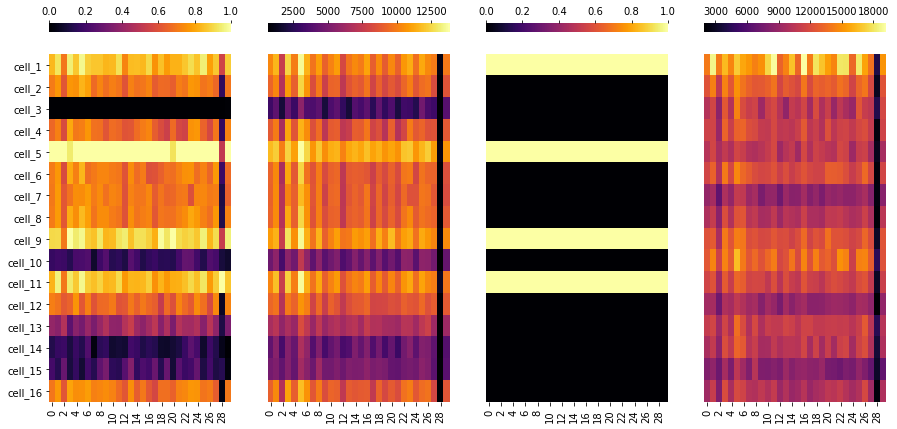

['cell_9', 'cell_11', 'cell_1', 'cell_5']


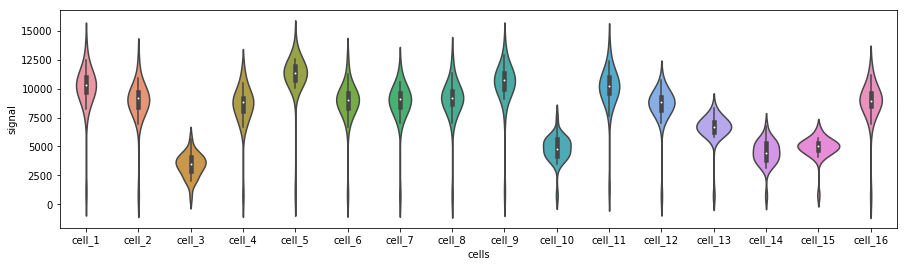

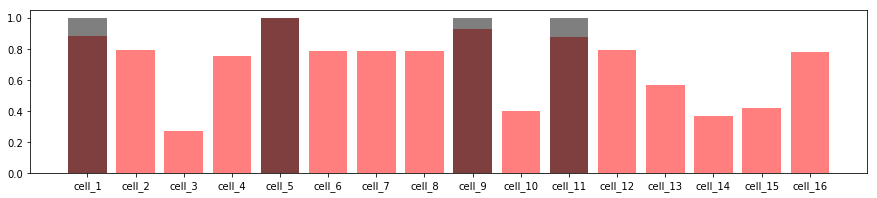

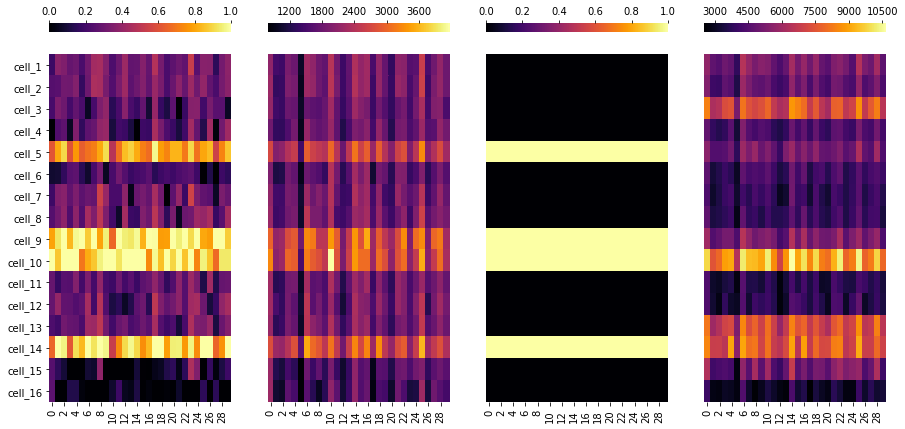

['cell_14', 'cell_10', 'cell_5', 'cell_9']


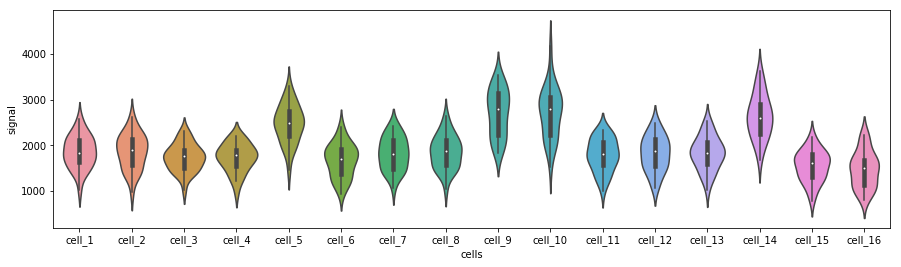

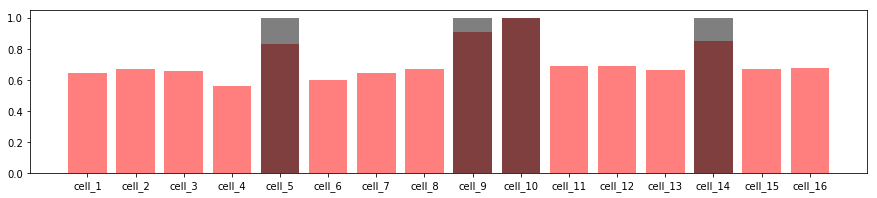

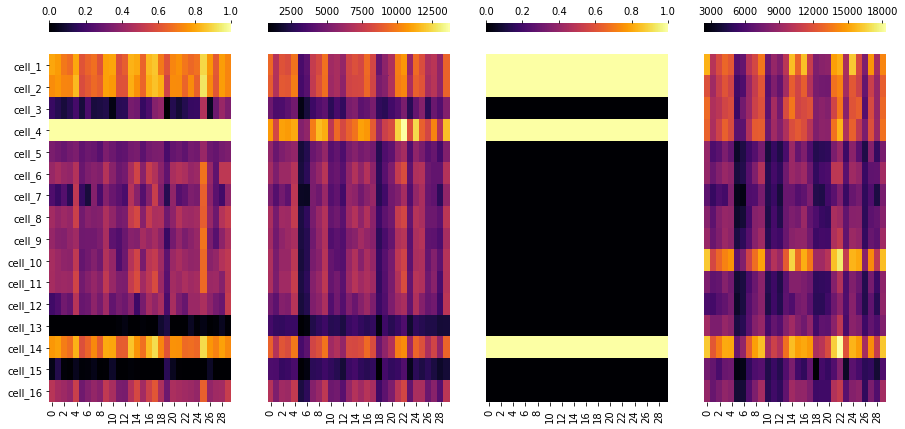

['cell_4', 'cell_2', 'cell_1', 'cell_14']


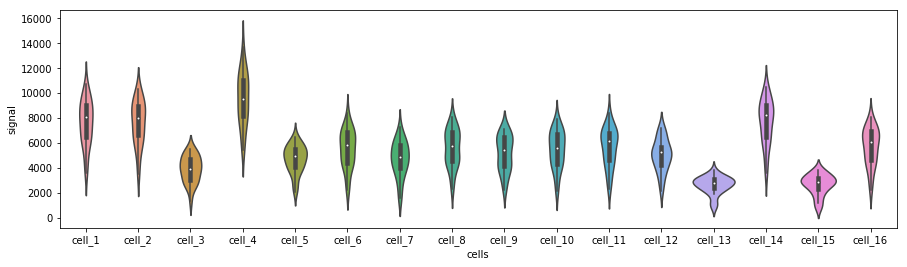

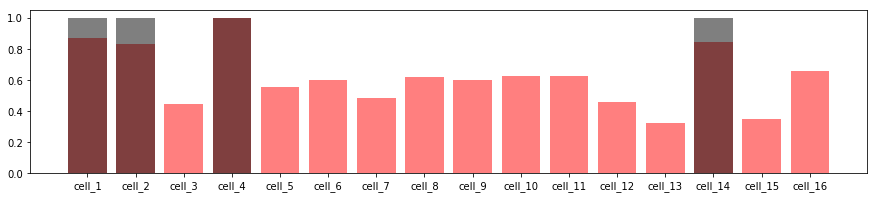

In [67]:
Gene_Matrix_Avg = pickle.load(open(os.path.join(base_path,'Gene_Matrix_Avg_Neuron_SizeNorm.pkl'),'rb'))
Gene_Matrix_std = pickle.load(open(os.path.join(base_path,'Gene_Matrix_std_Neuron_SizeNorm.pkl'),'rb'))
codebook_df = pd.DataFrame(index=Gene_Matrix_Avg.columns)
pfunc = partial(test_gene_picking,
                Gene_Matrix_Avg=Gene_Matrix_Avg,
                Gene_Matrix_std=Gene_Matrix_std,
                codebook_df=codebook_df,
                ngenes=50, 
                gene_keepers=10,
                gene_fold_thresh=1,
                gene_difference_thresh=10,
                gene_noise=1,
                gene_offspring_size=3,
                gene_mutation_rate_info=[30,100,1],
                gene_iterations=200,
                gene_A=0,
                gene_verbose=False,
                filter_genes=False,
                gene_metric_parameter=-10,
                gene_display='distance',
                log=True)
for i in range(5):
    gene_tester(pfunc)

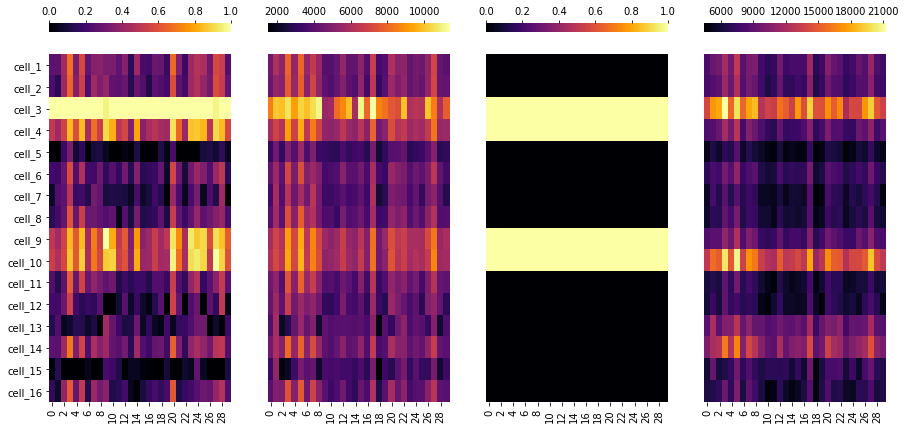

['cell_9', 'cell_3', 'cell_10', 'cell_4']


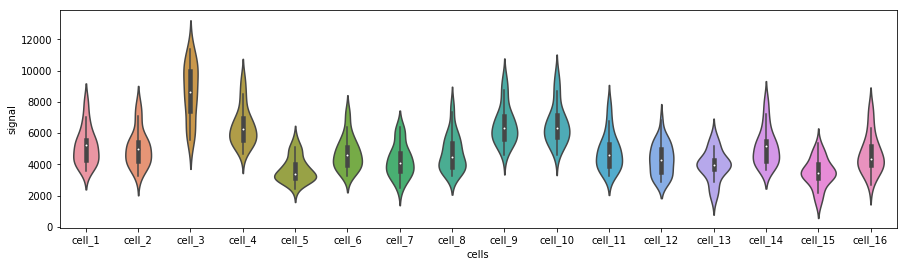

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:41: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


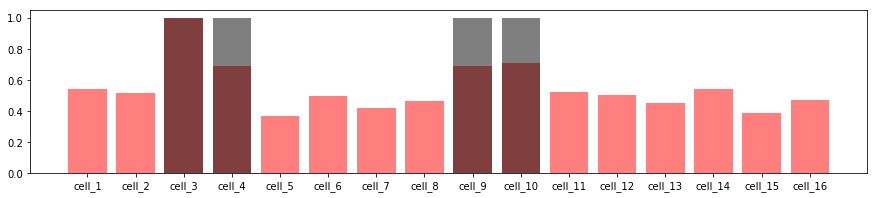

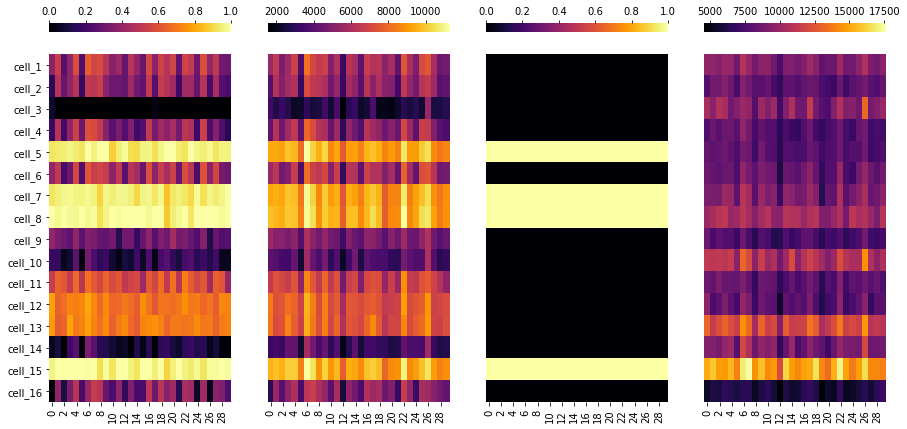

['cell_8', 'cell_5', 'cell_7', 'cell_15']


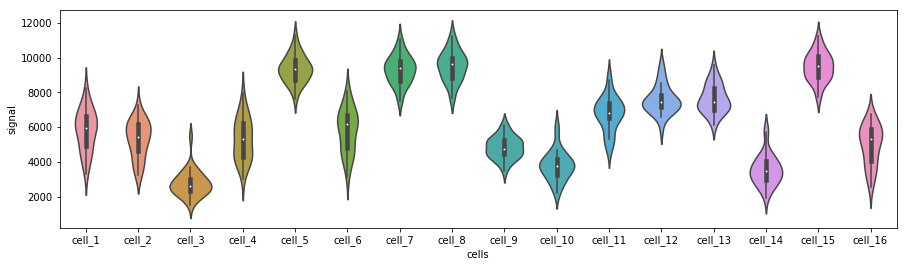

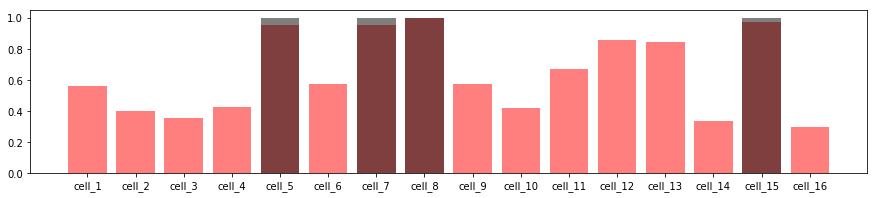

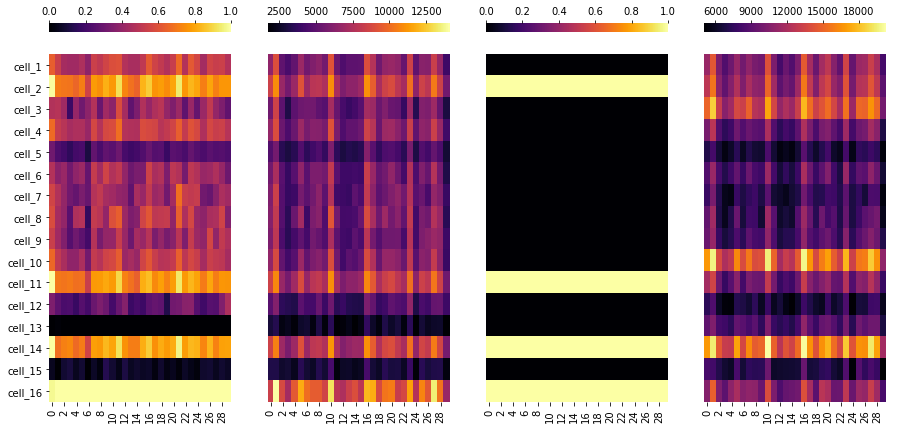

['cell_11', 'cell_14', 'cell_2', 'cell_16']


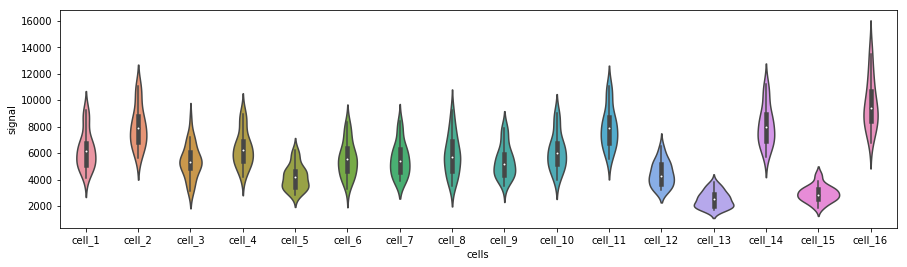

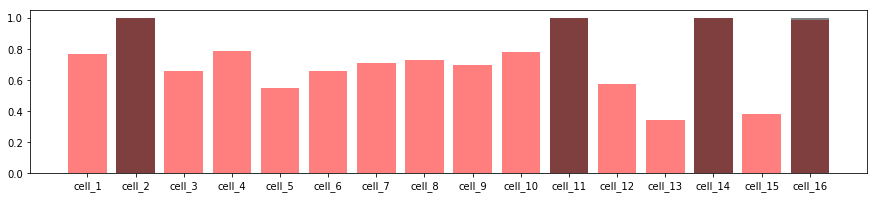

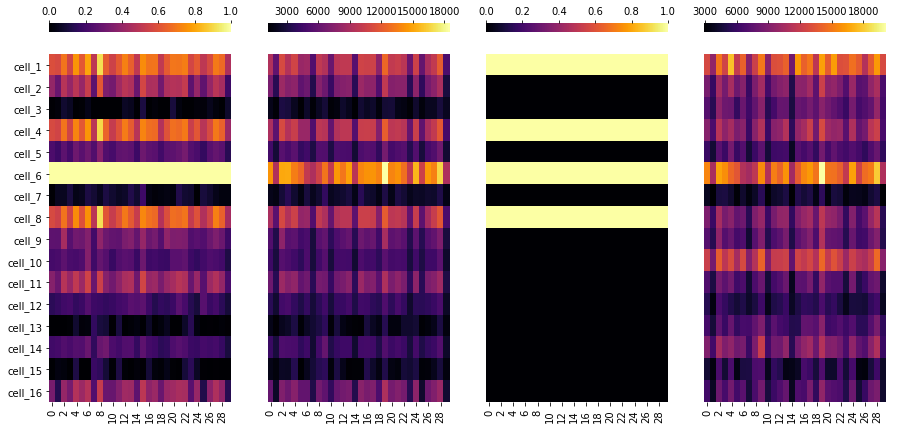

['cell_6', 'cell_4', 'cell_8', 'cell_1']


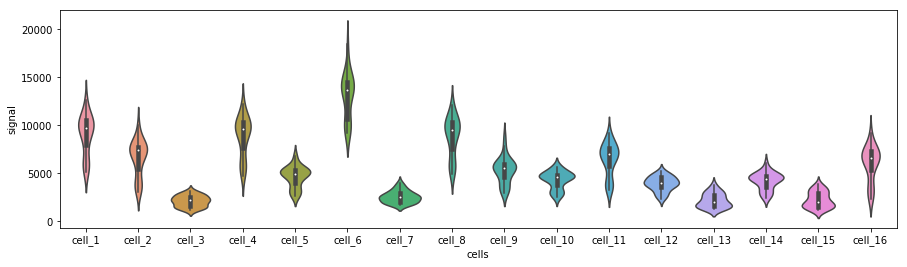

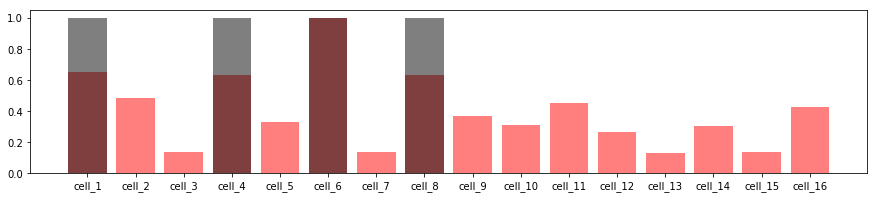

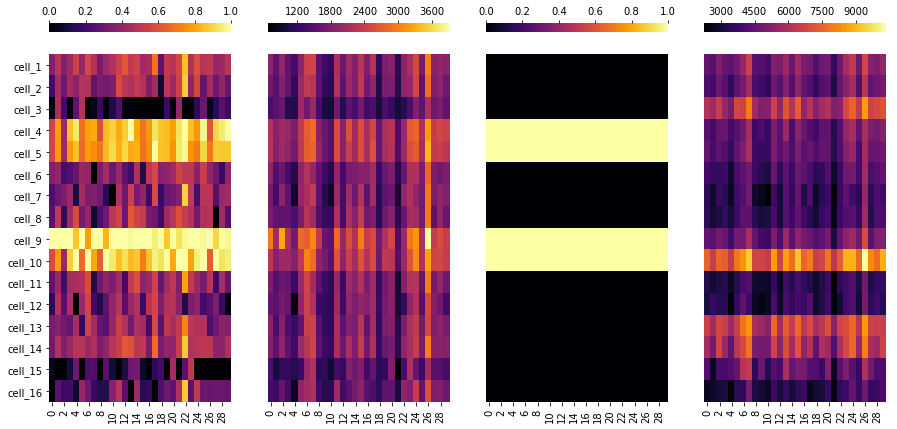

['cell_10', 'cell_5', 'cell_4', 'cell_9']


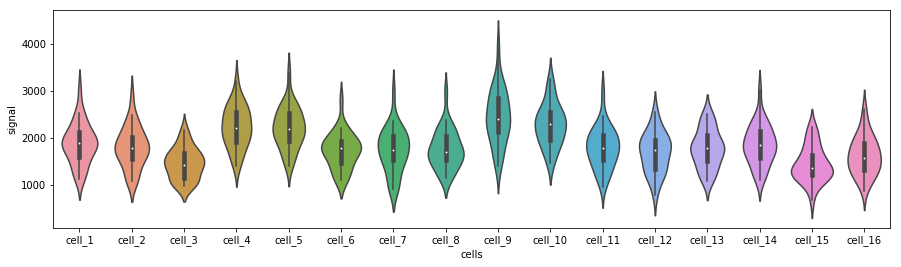

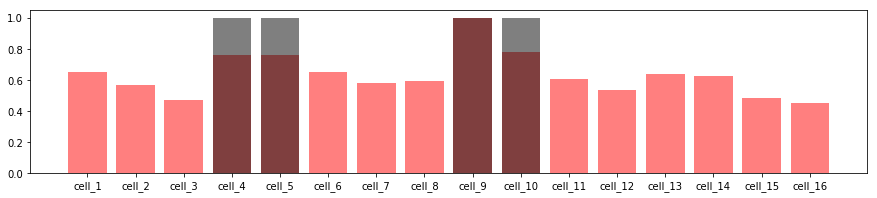

In [63]:
Gene_Matrix_Avg = pickle.load(open(os.path.join(base_path,'Gene_Matrix_Avg_Neuron_SizeNorm.pkl'),'rb'))
Gene_Matrix_std = pickle.load(open(os.path.join(base_path,'Gene_Matrix_std_Neuron_SizeNorm.pkl'),'rb'))
codebook_df = pd.DataFrame(index=Gene_Matrix_Avg.columns)
pfunc = partial(test_gene_picking,
                Gene_Matrix_Avg=Gene_Matrix_Avg,
                Gene_Matrix_std=Gene_Matrix_std,
                codebook_df=codebook_df,
                ngenes=50, 
                gene_keepers=10,
                gene_fold_thresh=1,
                gene_difference_thresh=10,
                gene_noise=1,
                gene_offspring_size=3,
                gene_mutation_rate_info=[30,100,1],
                gene_iterations=200,
                gene_A=0,
                gene_verbose=False,
                filter_genes=False,
                gene_metric_parameter=-3,
                gene_display='distance',
                log=True)
for i in range(5):
    gene_tester(pfunc)

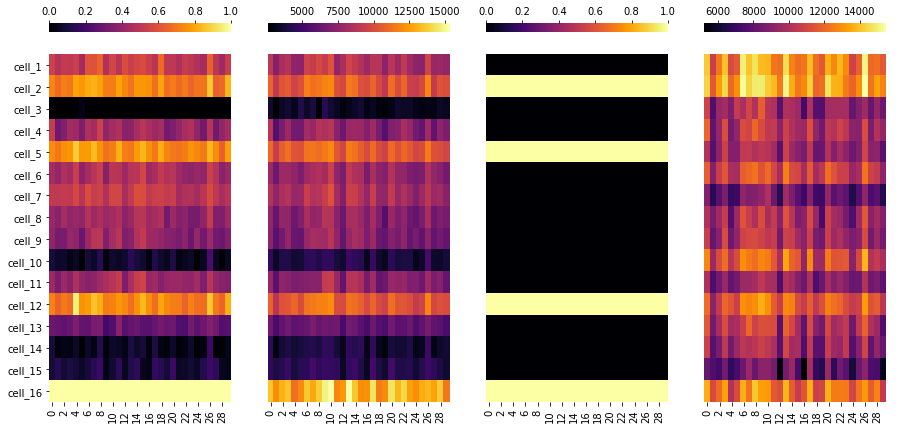

['cell_5', 'cell_2', 'cell_12', 'cell_16']


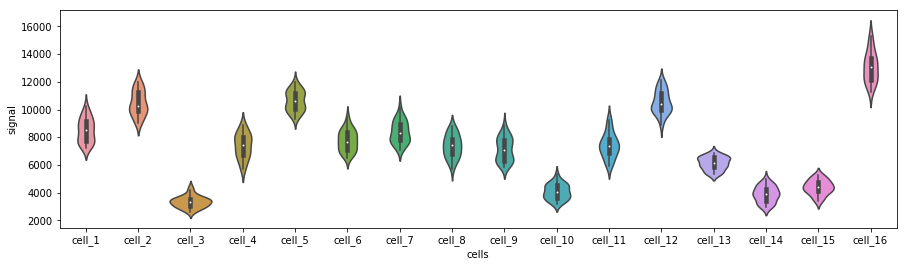

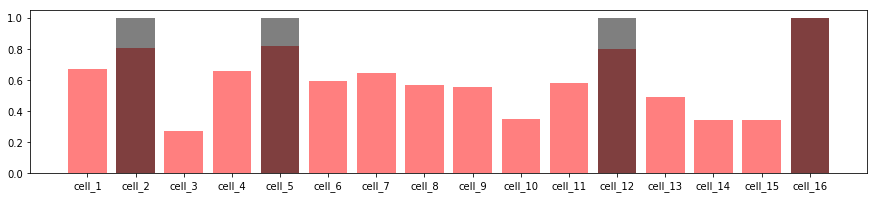

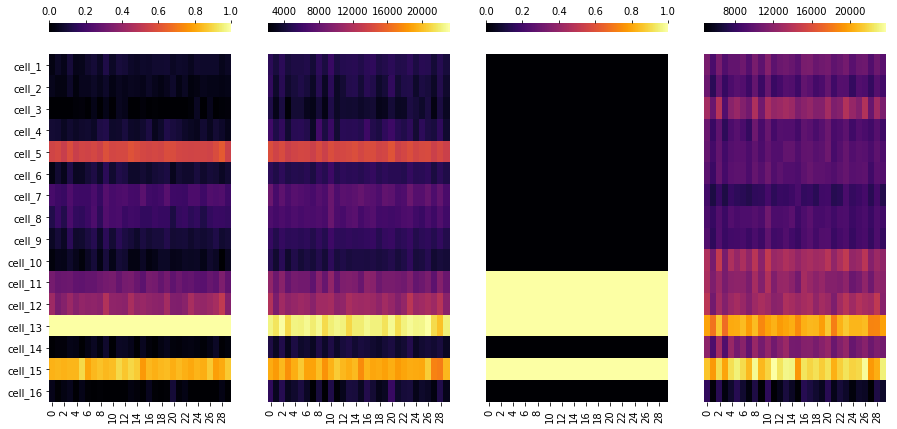

['cell_12', 'cell_11', 'cell_13', 'cell_15']


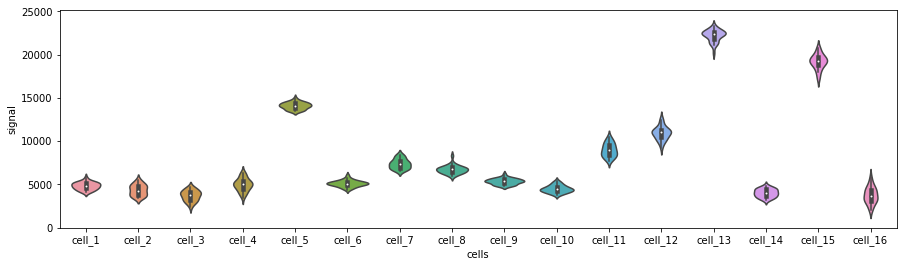

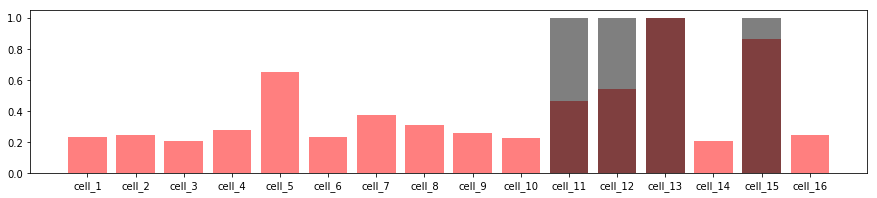

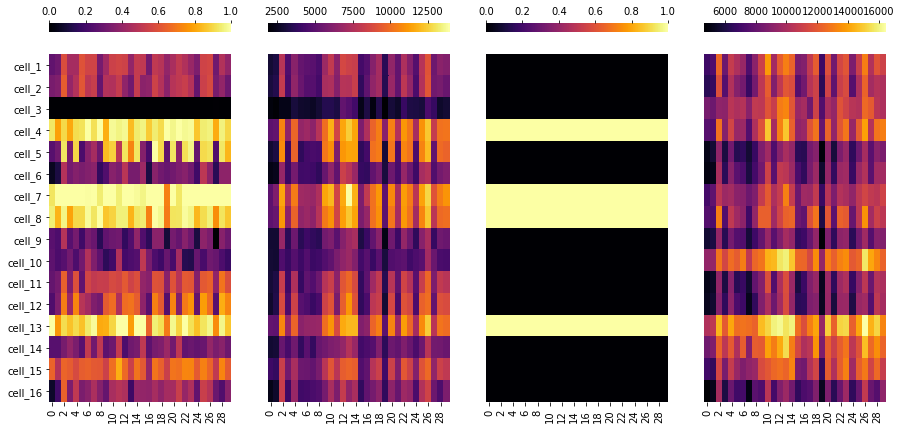

['cell_8', 'cell_13', 'cell_7', 'cell_4']


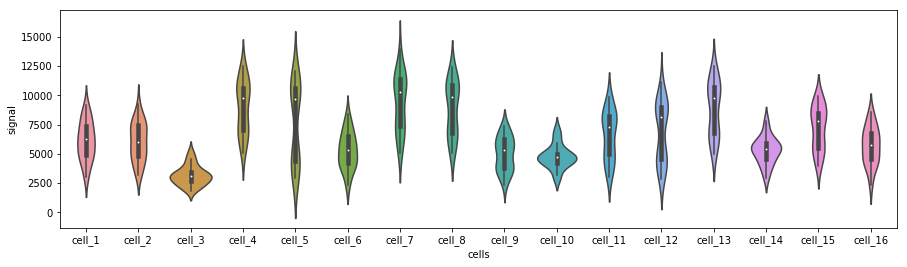

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:41: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


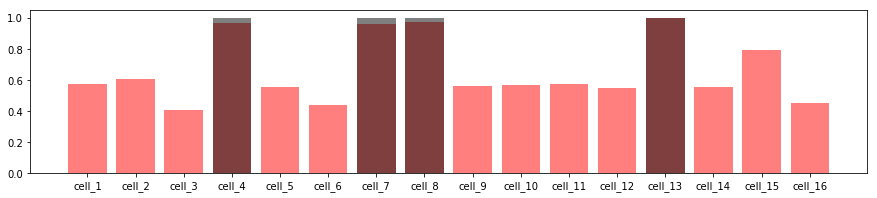

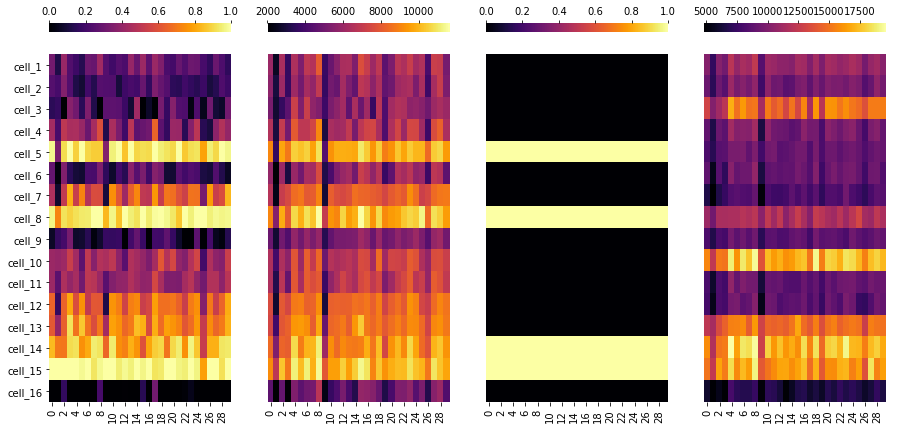

['cell_5', 'cell_15', 'cell_14', 'cell_8']


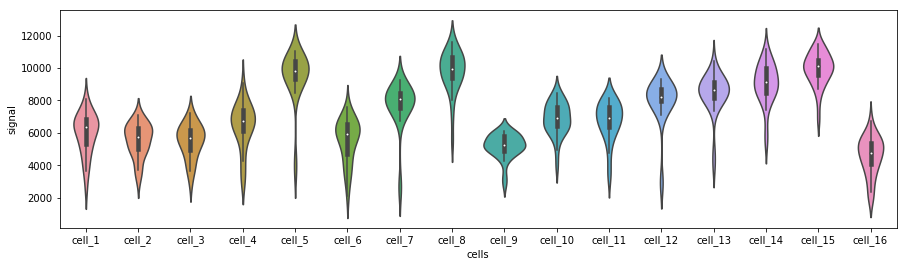

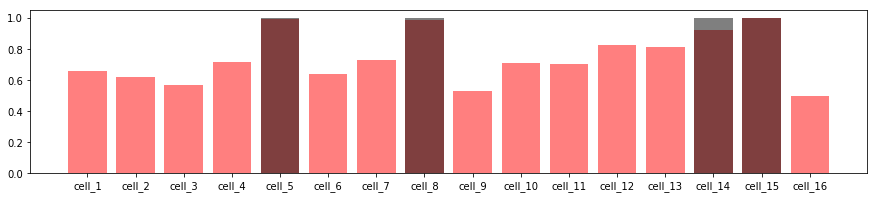

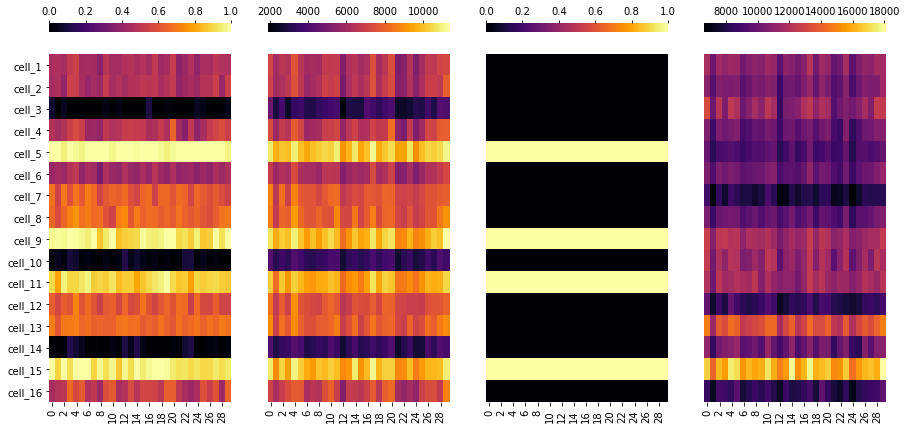

['cell_11', 'cell_15', 'cell_9', 'cell_5']


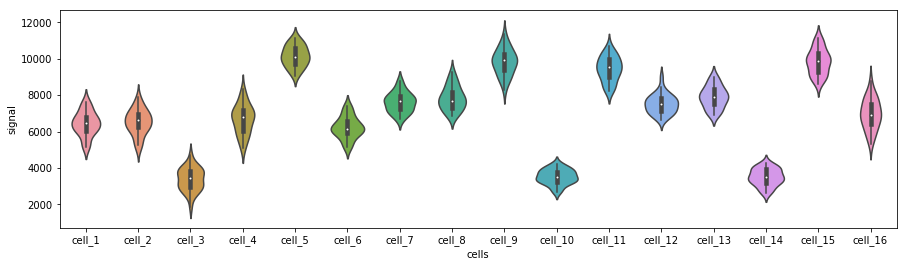

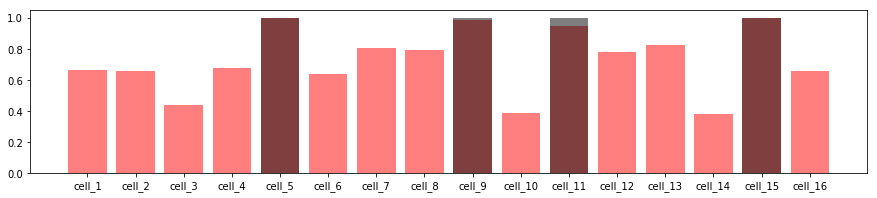

In [64]:
Gene_Matrix_Avg = pickle.load(open(os.path.join(base_path,'Gene_Matrix_Avg_Neuron_SizeNorm.pkl'),'rb'))
Gene_Matrix_std = pickle.load(open(os.path.join(base_path,'Gene_Matrix_std_Neuron_SizeNorm.pkl'),'rb'))
codebook_df = pd.DataFrame(index=Gene_Matrix_Avg.columns)
pfunc = partial(test_gene_picking,
                Gene_Matrix_Avg=Gene_Matrix_Avg,
                Gene_Matrix_std=Gene_Matrix_std,
                codebook_df=codebook_df,
                ngenes=50, 
                gene_keepers=10,
                gene_fold_thresh=1,
                gene_difference_thresh=10,
                gene_noise=1,
                gene_offspring_size=3,
                gene_mutation_rate_info=[30,100,1],
                gene_iterations=200,
                gene_A=0,
                gene_verbose=False,
                filter_genes=False,
                gene_metric_parameter=-1,
                gene_display='distance',
                log=True)
for i in range(5):
    gene_tester(pfunc)

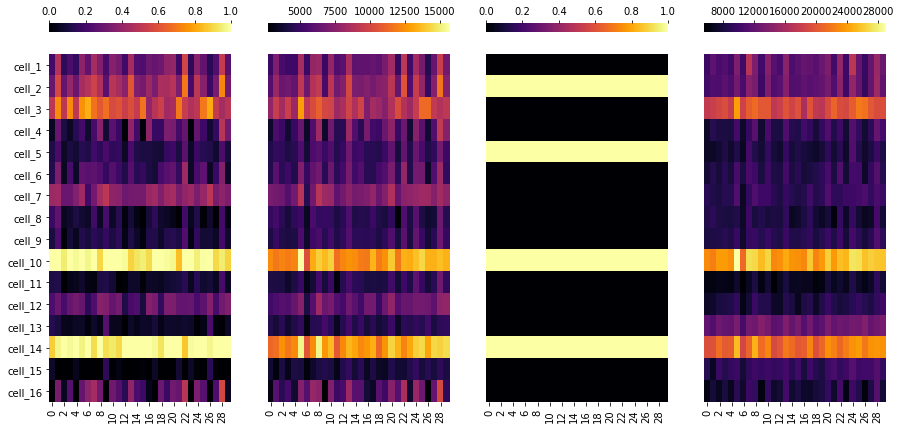

['cell_10', 'cell_2', 'cell_14', 'cell_5']


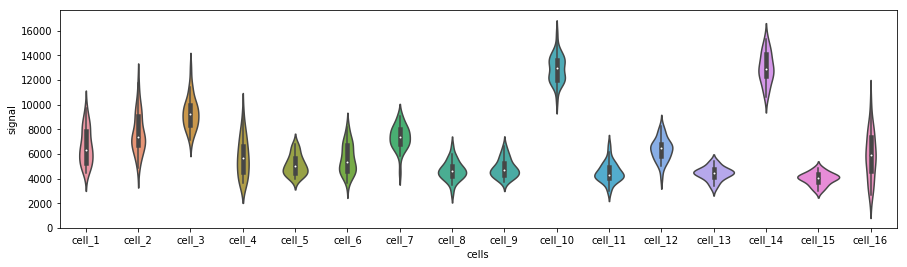

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:41: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


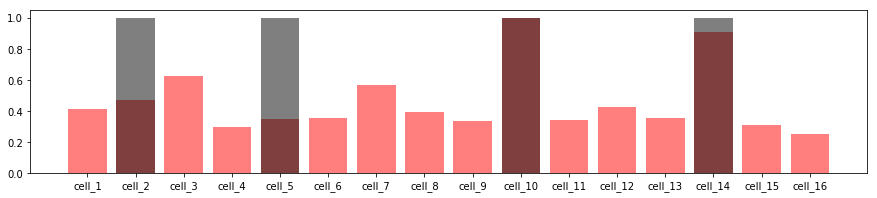

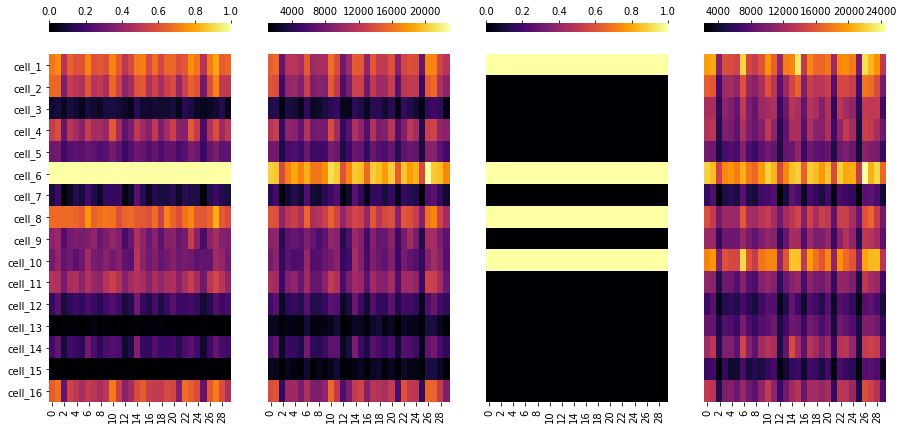

['cell_1', 'cell_8', 'cell_10', 'cell_6']


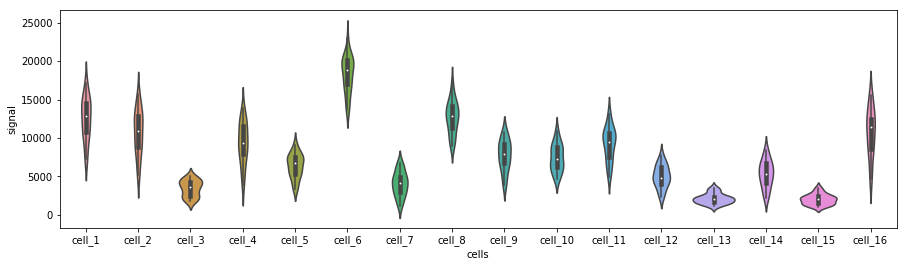

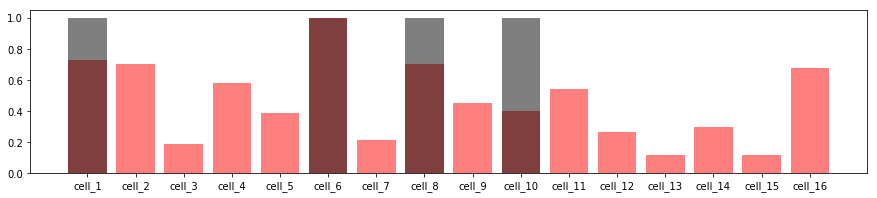

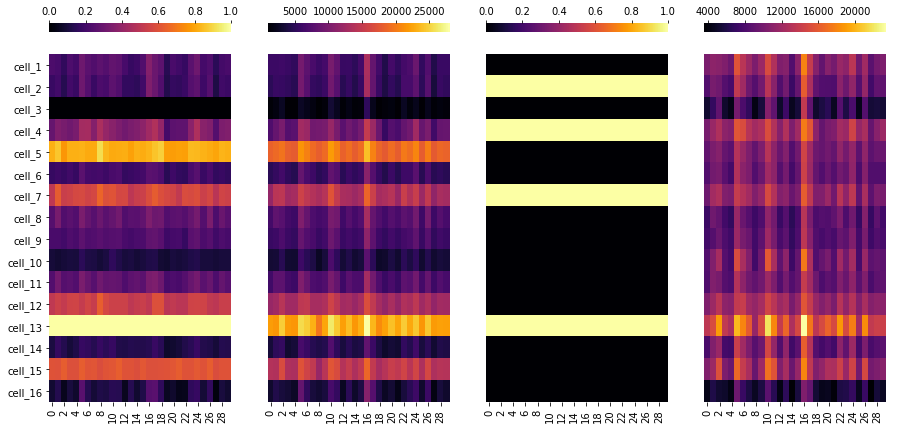

['cell_2', 'cell_4', 'cell_7', 'cell_13']


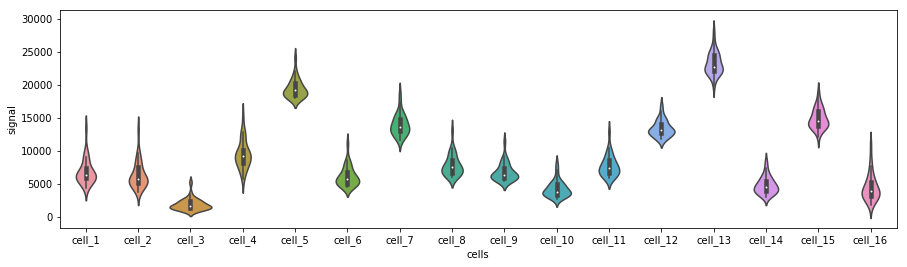

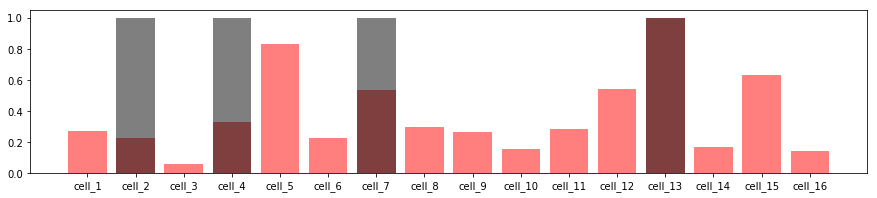

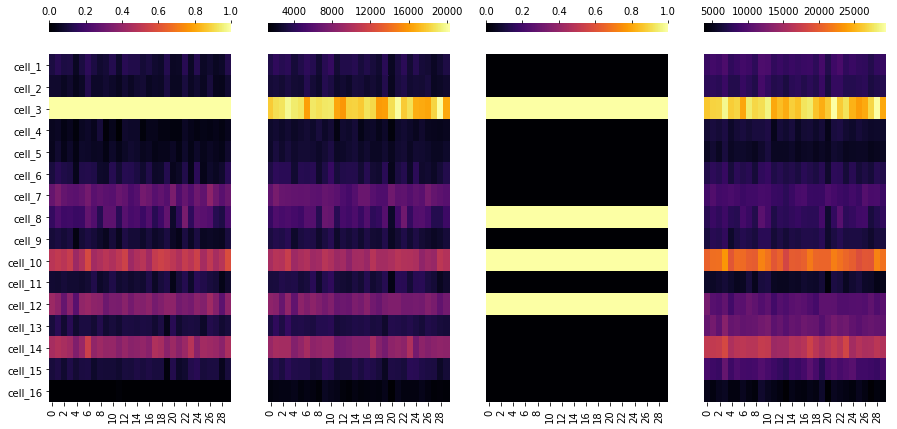

['cell_12', 'cell_10', 'cell_3', 'cell_8']


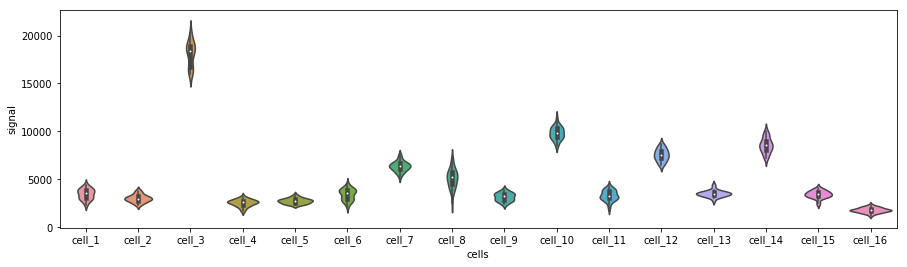

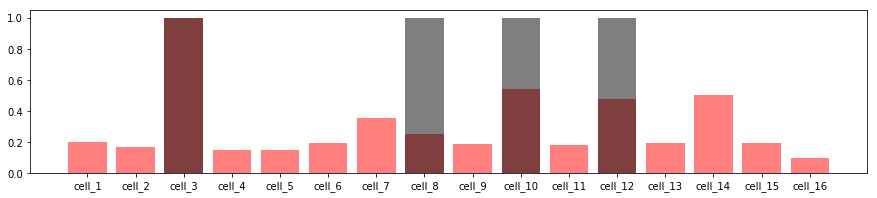

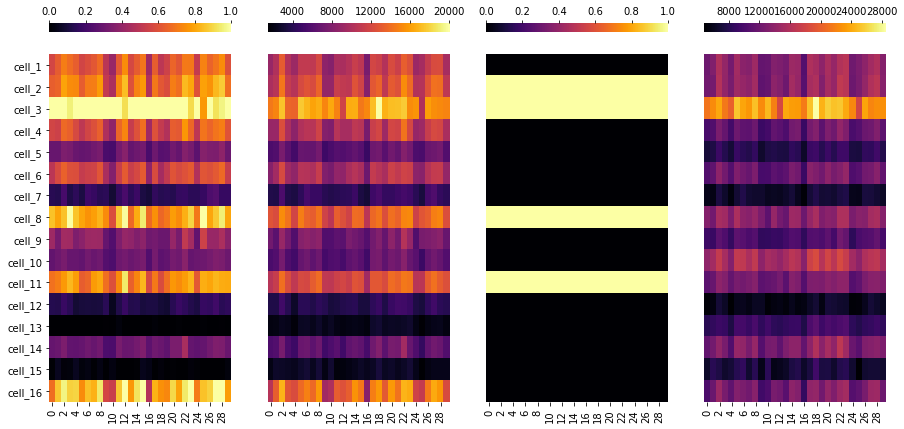

['cell_2', 'cell_3', 'cell_8', 'cell_11']


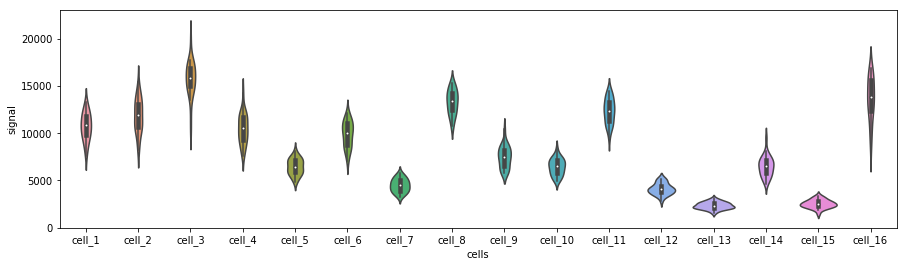

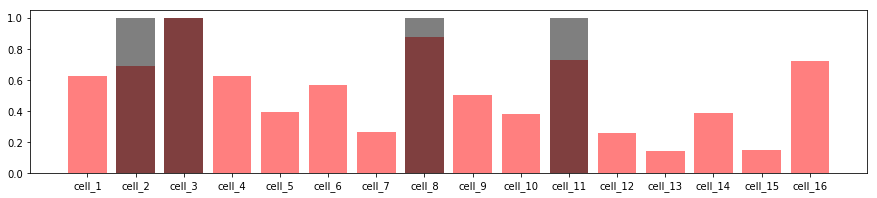

In [65]:
Gene_Matrix_Avg = pickle.load(open(os.path.join(base_path,'Gene_Matrix_Avg_Neuron_SizeNorm.pkl'),'rb'))
Gene_Matrix_std = pickle.load(open(os.path.join(base_path,'Gene_Matrix_std_Neuron_SizeNorm.pkl'),'rb'))
codebook_df = pd.DataFrame(index=Gene_Matrix_Avg.columns)
pfunc = partial(test_gene_picking,
                Gene_Matrix_Avg=Gene_Matrix_Avg,
                Gene_Matrix_std=Gene_Matrix_std,
                codebook_df=codebook_df,
                ngenes=50, 
                gene_keepers=10,
                gene_fold_thresh=1,
                gene_difference_thresh=10,
                gene_noise=1,
                gene_offspring_size=3,
                gene_mutation_rate_info=[30,100,1],
                gene_iterations=200,
                gene_A=0,
                gene_verbose=False,
                filter_genes=False,
                gene_metric_parameter=0,
                gene_display='distance',
                log=True)
for i in range(5):
    gene_tester(pfunc)

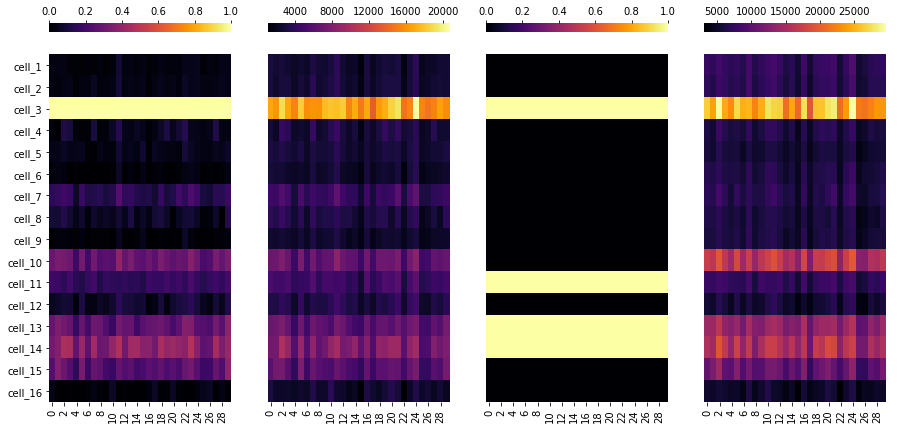

['cell_11', 'cell_13', 'cell_3', 'cell_14']


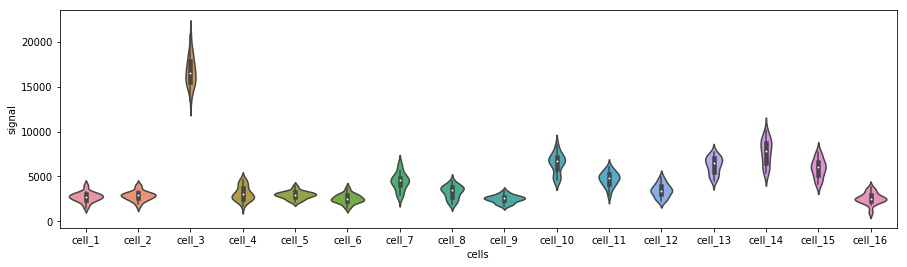

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:41: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


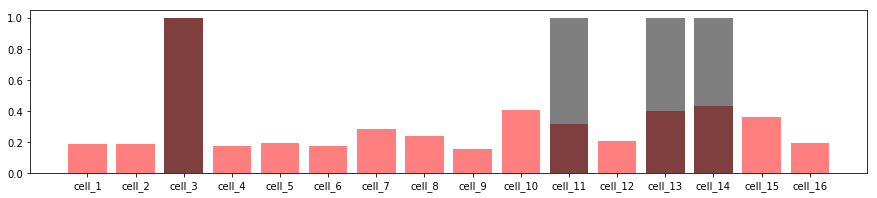

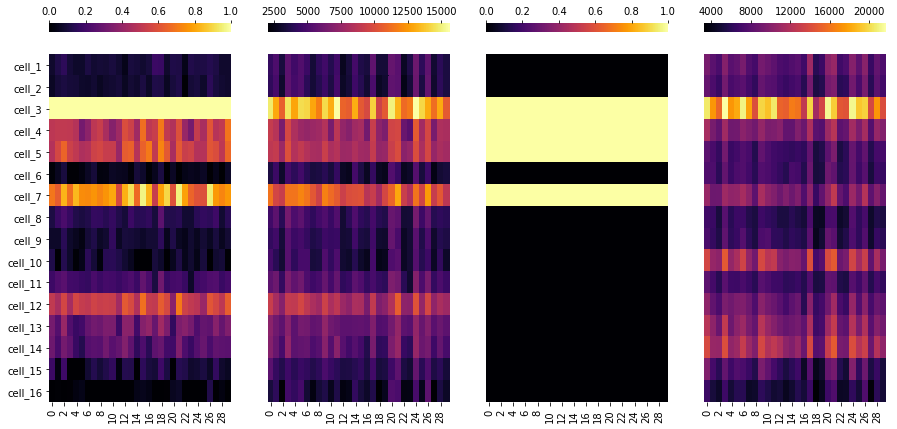

['cell_5', 'cell_3', 'cell_4', 'cell_7']


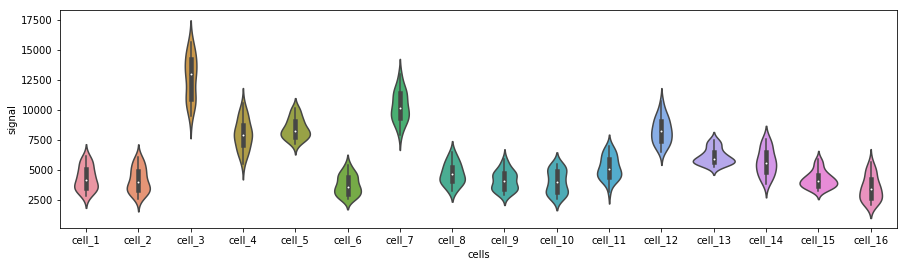

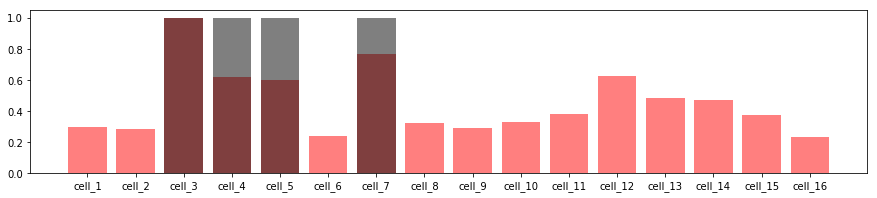

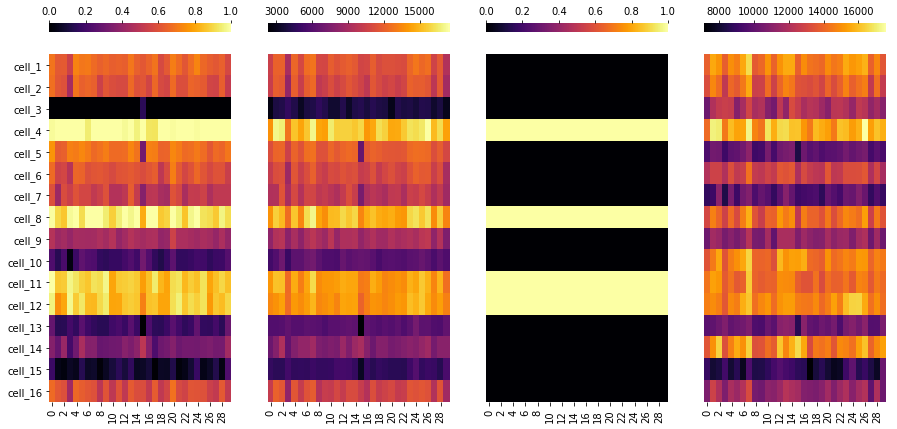

['cell_11', 'cell_4', 'cell_8', 'cell_12']


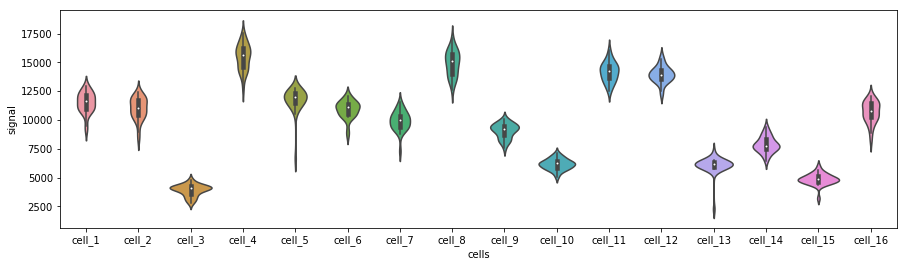

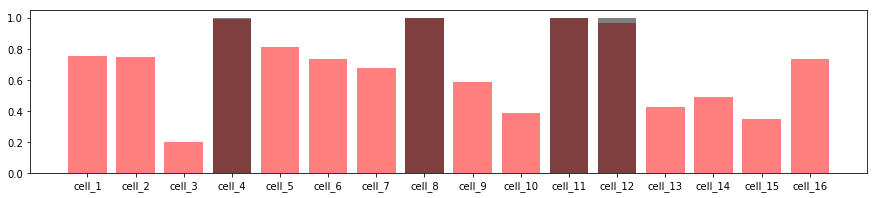

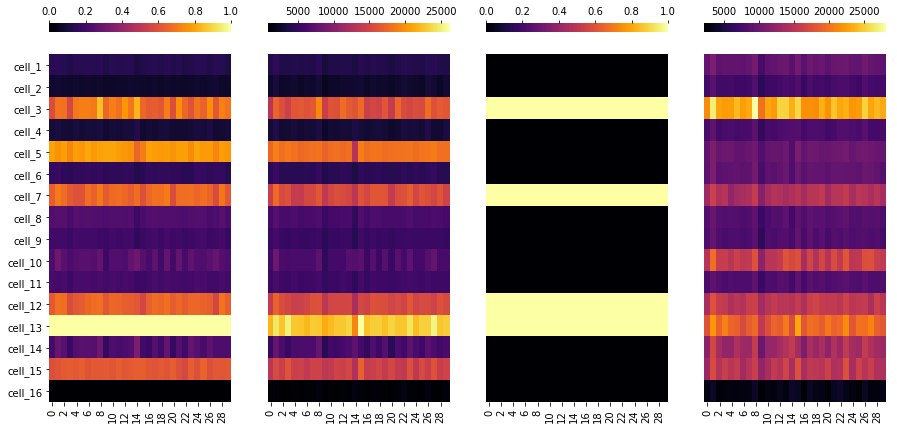

['cell_3', 'cell_13', 'cell_7', 'cell_12']


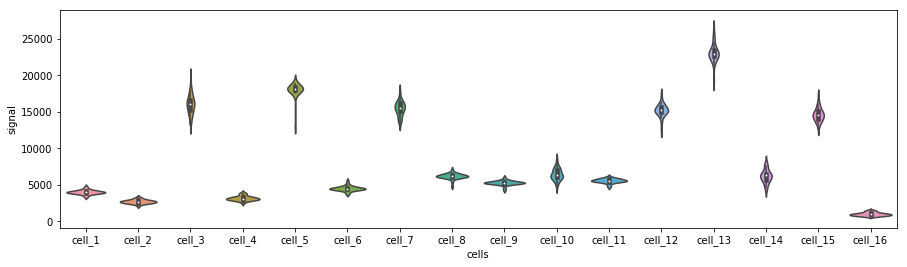

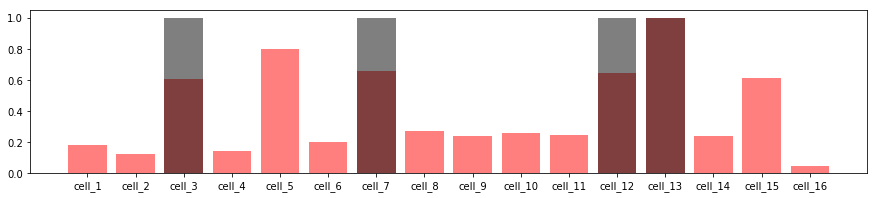

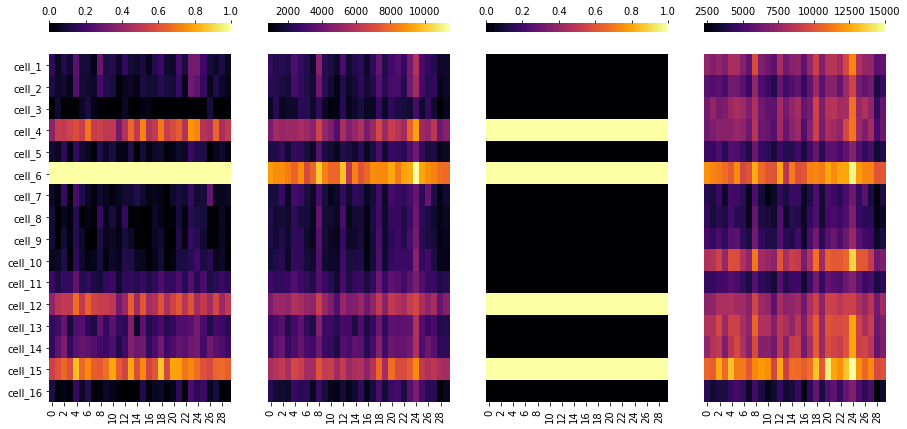

['cell_12', 'cell_15', 'cell_4', 'cell_6']


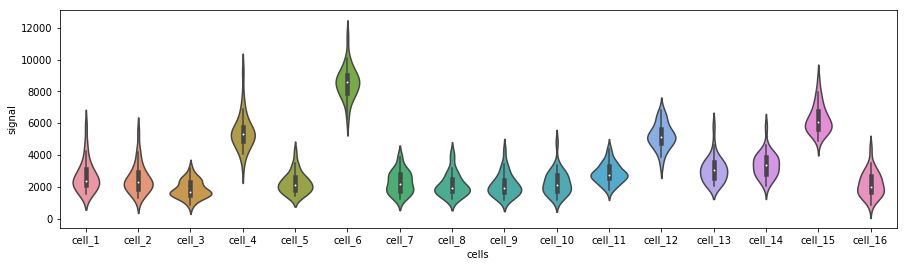

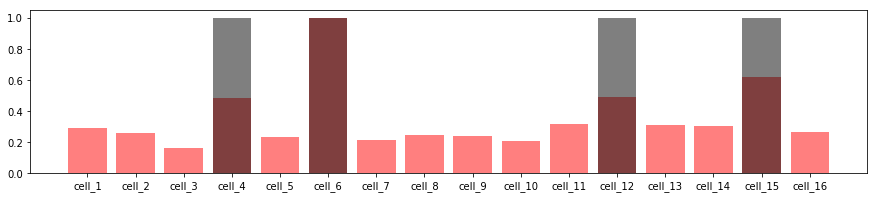

In [66]:
Gene_Matrix_Avg = pickle.load(open(os.path.join(base_path,'Gene_Matrix_Avg_Neuron_SizeNorm.pkl'),'rb'))
Gene_Matrix_std = pickle.load(open(os.path.join(base_path,'Gene_Matrix_std_Neuron_SizeNorm.pkl'),'rb'))
codebook_df = pd.DataFrame(index=Gene_Matrix_Avg.columns)
pfunc = partial(test_gene_picking,
                Gene_Matrix_Avg=Gene_Matrix_Avg,
                Gene_Matrix_std=Gene_Matrix_std,
                codebook_df=codebook_df,
                ngenes=50, 
                gene_keepers=10,
                gene_fold_thresh=1,
                gene_difference_thresh=10,
                gene_noise=1,
                gene_offspring_size=3,
                gene_mutation_rate_info=[30,100,1],
                gene_iterations=200,
                gene_A=0,
                gene_verbose=False,
                filter_genes=False,
                gene_metric_parameter=-0.5,
                gene_display='distance',
                log=True)
for i in range(5):
    gene_tester(pfunc)

In [58]:
def gene_qc(out_genes,Gene_Matrix_Avg,Gene_Matrix_std):
    genes = []
    for i in out_genes:
        genes.extend(i)
    g = []
    c = []
    p = []
    n = []
    ps = []
    ns = []
    blank = 0
    neg_cells = [i for i in Gene_Matrix_Avg.columns if not i in pos_cells]
    for gene,cc in Counter(genes).items():
        if 'blank' in gene:
            blank+=cc
            continue
        g.append(gene)
        c.append(cc)
        p.append(np.max(Gene_Matrix_Avg[pos_cells].loc[gene]))
        n.append(np.max(Gene_Matrix_Avg[neg_cells].loc[gene]))
        ps.append(np.max(Gene_Matrix_std[pos_cells].loc[gene]))
        ns.append(np.max(Gene_Matrix_std[neg_cells].loc[gene]))
    # g.append('blank')
    # c.append(blank)
    # p.append(0)
    # n.append(0)
    # ps.append(0)
    # ns.append(0)

    result = pd.DataFrame(index=g)
    result['c'] = c
    result['p'] = p
    result['n'] = n
    result['ps'] = ps
    result['ns'] = ns
    result = result.sort_values(by='c',ascending=False)
    return result

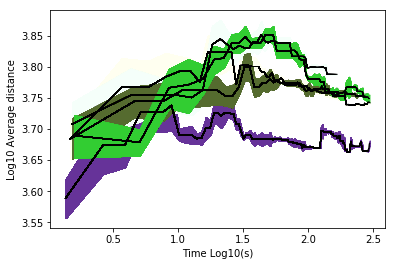

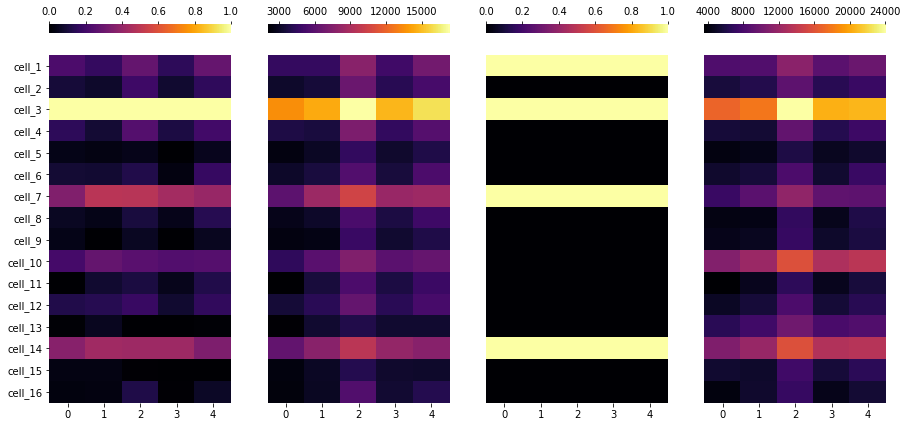

In [16]:
Gene_Matrix_Avg = pickle.load(open(os.path.join(base_path,'Gene_Matrix_Avg_Neuron_SizeNorm.pkl'),'rb'))
Gene_Matrix_std = pickle.load(open(os.path.join(base_path,'Gene_Matrix_std_Neuron_SizeNorm.pkl'),'rb'))
self = CodebookClass(Gene_Matrix_Avg,Gene_Matrix_std,base_path=os.path.join(base_path,'Neuron_Results_SizeNorm_1'),
   nbits=6,keepers=10,hamming=2,positive_bits=3,ngenes=50, gene_keepers=10,gene_fold_thresh=1,
   gene_difference_thresh=10,gene_noise=1,gene_offspring_size=3,gene_mutation_rate_info=[30,100,1],
   gene_iterations=200,gene_A=0,gene_verbose=True,substitution_rate=0,swap_rate=0,
   mutation_rate=10,offspring_rate=10,color='r',ncpu=1,iterations=1000,verbose=True,
   fresh=False,filter_genes=False,metric_parameter=-1,gene_metric_parameter=-1,gene_display='distance',display='distance')
signal_df = pd.DataFrame(index=Gene_Matrix_Avg.columns)
codebook_df = pd.DataFrame(index=Gene_Matrix_Avg.columns)
signal_std_df = pd.DataFrame(index=Gene_Matrix_Avg.columns)
pos = []
pos_cells = random.sample(list(Gene_Matrix_Avg.columns),4)
for x in range(5):
    color = random.sample(list(mcd.CSS4_COLORS.keys()),1)
#     pos_cells = random.sample(list(Gene_Matrix_Avg.columns),4)
    c = []
    for i in codebook_df.index:
        if i in pos_cells:
            c.append(1)
        else:
            c.append(0)
    codebook_df[x] = c
    pos.append(pos_cells)
    print(pos_cells)
    neg_cells = [i for i in Gene_Matrix_Avg.columns if not i in pos_cells]
    Gene_class = GeneClass(self.Gene_Matrix_Avg,self.Gene_Matrix_std,pos_cells,neg_cells=neg_cells,
       ngenes=self.ngenes,keepers=self.gene_keepers,fold_thresh=self.gene_fold_thresh,
       difference_thresh=self.gene_difference_thresh,noise=self.gene_noise,offspring_size=self.gene_offspring_size,
       mutation_rate_info=self.gene_mutation_rate_info,iterations=self.gene_iterations,
       color=color,A=self.gene_A,verbose=self.gene_verbose,filter_genes=self.filter_genes,
       log=self.log,metric_parameter=self.gene_metric_parameter,display=self.gene_display)
    Gene_class.evolve()
    base = ''.join(i+'_' for i in sorted(pos_cells))
    species = [g for g in Gene_class.elite_survivor if not 'blank' in g]
    signal = np.sum(Gene_Matrix_Avg.loc[species],axis=0)
    signal_std = np.sum(Gene_Matrix_std.loc[species],axis=0)
    signal_df[x] = signal
    signal_std_df[x] = signal_std
fig, axes = plt.subplots(ncols=4, figsize=(15, 8))
ax1,ax2,ax3,ax4 = axes
norm_df = signal_df.copy()
norm_df = norm_df-np.min(norm_df,axis=0)
norm_df = norm_df/np.max(norm_df,axis=0)
im2 = sns.heatmap(norm_df,cmap='inferno',ax=ax1,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=True)
im2 = sns.heatmap(signal_df,cmap='inferno',ax=ax2,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
im3 = sns.heatmap(signal_std_df,cmap='inferno',ax=ax4,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
im4 = sns.heatmap(codebook_df,cmap='inferno',ax=ax3,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
plt.show()

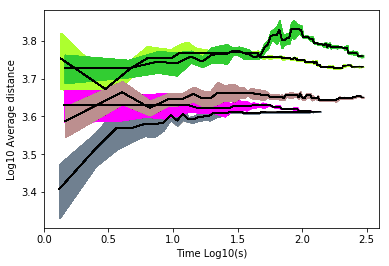

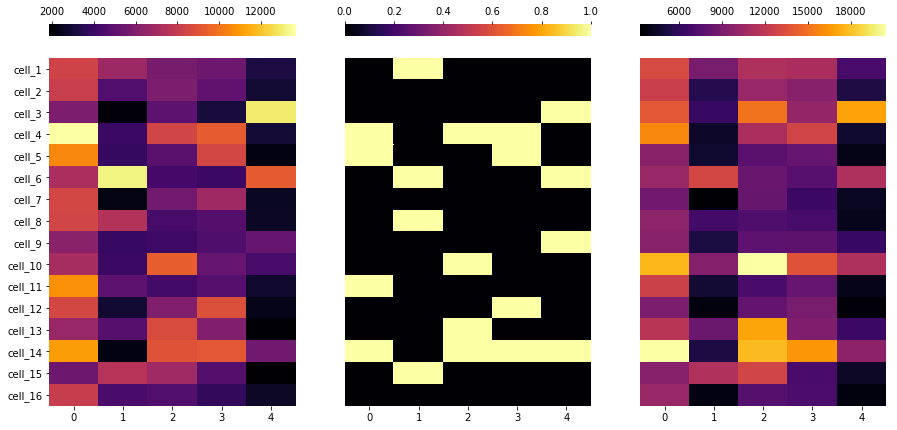

In [5]:
Gene_Matrix_Avg = pickle.load(open(os.path.join(base_path,'Gene_Matrix_Avg_Neuron_SizeNorm.pkl'),'rb'))
Gene_Matrix_std = pickle.load(open(os.path.join(base_path,'Gene_Matrix_std_Neuron_SizeNorm.pkl'),'rb'))
self = CodebookClass(Gene_Matrix_Avg,Gene_Matrix_std,base_path=os.path.join(base_path,'Neuron_Results_SizeNorm_1'),
   nbits=6,keepers=10,hamming=2,positive_bits=3,ngenes=50, gene_keepers=10,gene_fold_thresh=1,
   gene_difference_thresh=10,gene_noise=1,gene_offspring_size=3,gene_mutation_rate_info=[30,100,1],
   gene_iterations=200,gene_A=0,gene_verbose=True,substitution_rate=0,swap_rate=0,
   mutation_rate=10,offspring_rate=10,color='r',ncpu=1,iterations=1000,verbose=True,
   fresh=False,filter_genes=False,metric_parameter=-1,gene_metric_parameter=-1,gene_display='distance',display='distance')
signal_df = pd.DataFrame(index=Gene_Matrix_Avg.columns)
codebook_df = pd.DataFrame(index=Gene_Matrix_Avg.columns)
signal_std_df = pd.DataFrame(index=Gene_Matrix_Avg.columns)
pos = []

for x in range(5):
    color = random.sample(list(mcd.CSS4_COLORS.keys()),1)
    pos_cells = random.sample(list(Gene_Matrix_Avg.columns),4)
    c = []
    for i in codebook_df.index:
        if i in pos_cells:
            c.append(1)
        else:
            c.append(0)
    codebook_df[x] = c
    pos.append(pos_cells)
    print(pos_cells)
    neg_cells = [i for i in Gene_Matrix_Avg.columns if not i in pos_cells]
    Gene_class = GeneClass(self.Gene_Matrix_Avg,self.Gene_Matrix_std,pos_cells,neg_cells=neg_cells,
       ngenes=self.ngenes,keepers=self.gene_keepers,fold_thresh=self.gene_fold_thresh,
       difference_thresh=self.gene_difference_thresh,noise=self.gene_noise,offspring_size=self.gene_offspring_size,
       mutation_rate_info=self.gene_mutation_rate_info,iterations=self.gene_iterations,
       color=color,A=self.gene_A,verbose=self.gene_verbose,filter_genes=self.filter_genes,
       log=self.log,metric_parameter=self.gene_metric_parameter,display=self.gene_display)
    Gene_class.evolve()
    base = ''.join(i+'_' for i in sorted(pos_cells))
    species = [g for g in Gene_class.elite_survivor if not 'blank' in g]
    signal = np.sum(Gene_Matrix_Avg.loc[species],axis=0)
    signal_std = np.sum(Gene_Matrix_std.loc[species],axis=0)
    signal_df[x] = signal
    signal_std_df[x] = signal_std
fig, axes = plt.subplots(ncols=4, figsize=(15, 8))
ax1,ax2,ax3,ax4 = axes
norm_df = signal_df.copy()
norm_df = norm_df-np.min(norm_df,axis=0)
norm_df = norm_df/np.max(norm_df,axis=0)
im2 = sns.heatmap(norm_df,cmap='inferno',ax=ax1,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=True)
im2 = sns.heatmap(signal_df,cmap='inferno',ax=ax2,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
im3 = sns.heatmap(signal_std_df,cmap='inferno',ax=ax4,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
im4 = sns.heatmap(codebook_df,cmap='inferno',ax=ax3,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
plt.show()

KeyboardInterrupt: 

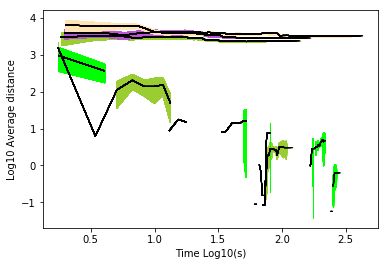

In [27]:
Gene_Matrix_Avg = pickle.load(open(os.path.join(base_path,'Gene_Matrix_Avg_Neuron_SizeNorm.pkl'),'rb'))
Gene_Matrix_std = pickle.load(open(os.path.join(base_path,'Gene_Matrix_std_Neuron_SizeNorm.pkl'),'rb'))
self = CodebookClass(Gene_Matrix_Avg,Gene_Matrix_std,base_path=os.path.join(base_path,'Neuron_Results_SizeNorm_1'),
   nbits=6,keepers=10,hamming=2,positive_bits=3,ngenes=50, gene_keepers=10,gene_fold_thresh=1,
   gene_difference_thresh=10,gene_noise=1,gene_offspring_size=3,gene_mutation_rate_info=[30,100,1],
   gene_iterations=200,gene_A=0,gene_verbose=True,substitution_rate=0,swap_rate=0,
   mutation_rate=10,offspring_rate=10,color='r',ncpu=1,iterations=1000,verbose=True,
   fresh=False,filter_genes=False,metric_parameter=-1,gene_metric_parameter=-2,gene_display='distance',display='distance')
signal_df = pd.DataFrame(index=Gene_Matrix_Avg.columns)
codebook_df = pd.DataFrame(index=Gene_Matrix_Avg.columns)
signal_std_df = pd.DataFrame(index=Gene_Matrix_Avg.columns)
pos = []

for x in range(10):
    color = random.sample(list(mcd.CSS4_COLORS.keys()),1)
    pos_cells = random.sample(list(Gene_Matrix_Avg.columns),4)
    c = []
    for i in codebook_df.index:
        if i in pos_cells:
            c.append(1)
        else:
            c.append(0)
    codebook_df[x] = c
    pos.append(pos_cells)
    print(pos_cells)
    neg_cells = [i for i in Gene_Matrix_Avg.columns if not i in pos_cells]
    Gene_class = GeneClass(self.Gene_Matrix_Avg,self.Gene_Matrix_std,pos_cells,neg_cells=neg_cells,
       ngenes=self.ngenes,keepers=self.gene_keepers,fold_thresh=self.gene_fold_thresh,
       difference_thresh=self.gene_difference_thresh,noise=self.gene_noise,offspring_size=self.gene_offspring_size,
       mutation_rate_info=self.gene_mutation_rate_info,iterations=self.gene_iterations,
       color=color,A=self.gene_A,verbose=self.gene_verbose,filter_genes=self.filter_genes,
       log=self.log,metric_parameter=self.gene_metric_parameter,display=self.gene_display)
    Gene_class.evolve()
    base = ''.join(i+'_' for i in sorted(pos_cells))
    species = [g for g in Gene_class.elite_survivor if not 'blank' in g]
    signal = np.sum(Gene_Matrix_Avg.loc[species],axis=0)
    signal_std = np.sum(Gene_Matrix_std.loc[species],axis=0)
    signal_df[x] = signal
    signal_std_df[x] = signal_std
fig, axes = plt.subplots(ncols=4, figsize=(15, 8))
ax1,ax2,ax3,ax4 = axes
norm_df = signal_df.copy()
norm_df = norm_df-np.min(norm_df,axis=0)
norm_df = norm_df/np.max(norm_df,axis=0)
im2 = sns.heatmap(norm_df,cmap='inferno',ax=ax1,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=True)
im2 = sns.heatmap(signal_df,cmap='inferno',ax=ax2,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
im3 = sns.heatmap(signal_std_df,cmap='inferno',ax=ax4,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
im4 = sns.heatmap(codebook_df,cmap='inferno',ax=ax3,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
plt.show()

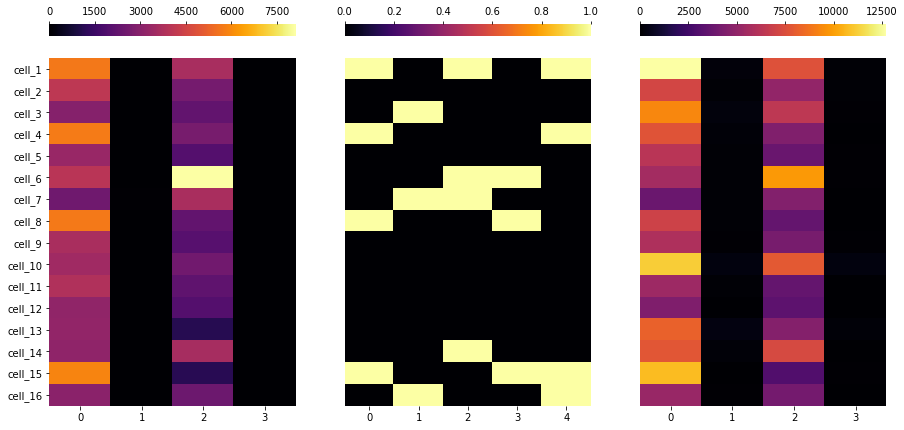

In [28]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 8))
ax2,ax3,ax4 = axes
im2 = sns.heatmap(signal_df,cmap='inferno',ax=ax2,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=True)
im3 = sns.heatmap(signal_std_df,cmap='inferno',ax=ax4,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
im4 = sns.heatmap(codebook_df,cmap='inferno',ax=ax3,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
plt.show()

In [ ]:
Gene_Matrix_Avg = pickle.load(open(os.path.join(base_path,'Gene_Matrix_Avg_Neuron_SizeNorm.pkl'),'rb'))
Gene_Matrix_std = pickle.load(open(os.path.join(base_path,'Gene_Matrix_std_Neuron_SizeNorm.pkl'),'rb'))
self = CodebookClass(Gene_Matrix_Avg,Gene_Matrix_std,base_path=os.path.join(base_path,'Neuron_Results_SizeNorm_1'),
   nbits=6,keepers=10,hamming=2,positive_bits=3,ngenes=50, gene_keepers=10,gene_fold_thresh=1,
   gene_difference_thresh=10,gene_noise=1,gene_offspring_size=3,gene_mutation_rate_info=[30,100,1],
   gene_iterations=200,gene_A=0,gene_verbose=True,substitution_rate=0,swap_rate=0,
   mutation_rate=10,offspring_rate=10,color='r',ncpu=1,iterations=1000,verbose=True,
   fresh=False,filter_genes=False,metric_parameter=-1,gene_metric_parameter=-0.5,gene_display='distance',display='distance')
signal_df = pd.DataFrame(index=Gene_Matrix_Avg.columns)
codebook_df = pd.DataFrame(index=Gene_Matrix_Avg.columns)
signal_std_df = pd.DataFrame(index=Gene_Matrix_Avg.columns)
pos = []

for x in range(10):
    color = random.sample(list(mcd.CSS4_COLORS.keys()),1)
    pos_cells = random.sample(list(Gene_Matrix_Avg.columns),4)
    c = []
    for i in codebook_df.index:
        if i in pos_cells:
            c.append(1)
        else:
            c.append(0)
    codebook_df[x] = c
    pos.append(pos_cells)
    print(pos_cells)
    neg_cells = [i for i in Gene_Matrix_Avg.columns if not i in pos_cells]
    Gene_class = GeneClass(self.Gene_Matrix_Avg,self.Gene_Matrix_std,pos_cells,neg_cells=neg_cells,
       ngenes=self.ngenes,keepers=self.gene_keepers,fold_thresh=self.gene_fold_thresh,
       difference_thresh=self.gene_difference_thresh,noise=self.gene_noise,offspring_size=self.gene_offspring_size,
       mutation_rate_info=self.gene_mutation_rate_info,iterations=self.gene_iterations,
       color=color,A=self.gene_A,verbose=self.gene_verbose,filter_genes=self.filter_genes,
       log=self.log,metric_parameter=self.gene_metric_parameter,display=self.gene_display)
    Gene_class.evolve()
    base = ''.join(i+'_' for i in sorted(pos_cells))
    species = [g for g in Gene_class.elite_survivor if not 'blank' in g]
    signal = np.sum(Gene_Matrix_Avg.loc[species],axis=0)
    signal_std = np.sum(Gene_Matrix_std.loc[species],axis=0)
    signal_df[x] = signal
    signal_std_df[x] = signal_std
fig, axes = plt.subplots(ncols=3, figsize=(15, 8))
ax2,ax3,ax4 = axes
im2 = sns.heatmap(signal_df,cmap='inferno',ax=ax2,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=True)
im3 = sns.heatmap(signal_std_df,cmap='inferno',ax=ax4,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
im4 = sns.heatmap(codebook_df,cmap='inferno',ax=ax3,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
plt.show()

KeyboardInterrupt: 

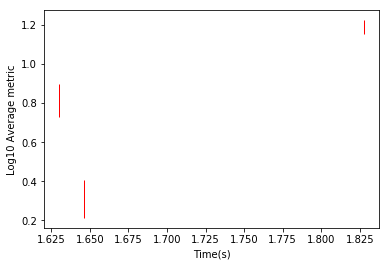

In [8]:
Gene_Matrix_Avg = pickle.load(open(os.path.join(base_path,'Gene_Matrix_Avg_Neuron_SizeNorm.pkl'),'rb'))
Gene_Matrix_std = pickle.load(open(os.path.join(base_path,'Gene_Matrix_std_Neuron_SizeNorm.pkl'),'rb'))
# Gene_Matrix_Avg.columns = ['cell_'+str(i) for i in Gene_Matrix_Avg.columns]
# Gene_Matrix_std.columns = ['cell_'+str(i) for i in Gene_Matrix_std.columns]
Codebook_Class = CodebookClass(Gene_Matrix_Avg,Gene_Matrix_std,base_path=os.path.join(base_path,'Neuron_Results_SizeNorm_1'),
   nbits=6,keepers=10,hamming=2,positive_bits=3,ngenes=50, gene_keepers=10,gene_fold_thresh=1,
   gene_difference_thresh=10,gene_noise=1,gene_offspring_size=3,gene_mutation_rate_info=[30,100,1],
   gene_iterations=100,gene_A=0,gene_verbose=True,substitution_rate=0,swap_rate=0,
   mutation_rate=10,offspring_rate=10,color='r',ncpu=1,iterations=1000,verbose=True,
   fresh=False,filter_genes=False,metric_parameter=-1,gene_metric_parameter=-1,gene_display='metric',display='distance')
Codebook_Class.evolve()

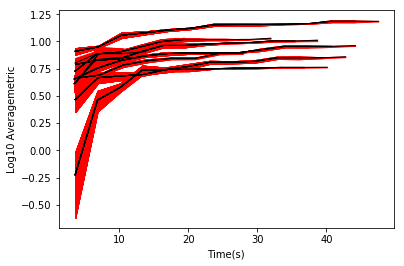

KeyboardInterrupt: 

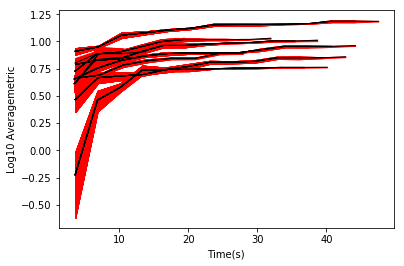

In [21]:
Gene_Matrix_Avg = pickle.load(open(os.path.join(base_path,'Gene_Matrix_Avg_Neuron_SizeNorm.pkl'),'rb'))
Gene_Matrix_std = pickle.load(open(os.path.join(base_path,'Gene_Matrix_std_Neuron_SizeNorm.pkl'),'rb'))
# Gene_Matrix_Avg.columns = ['cell_'+str(i) for i in Gene_Matrix_Avg.columns]
# Gene_Matrix_std.columns = ['cell_'+str(i) for i in Gene_Matrix_std.columns]
Codebook_Class = CodebookClass(Gene_Matrix_Avg,Gene_Matrix_std,base_path=os.path.join(base_path,'Neuron_Results_SizeNorm_1'),
   nbits=6,keepers=10,hamming=2,positive_bits=3,ngenes=50, gene_keepers=10,gene_fold_thresh=1,
   gene_difference_thresh=10,gene_noise=1,gene_offspring_size=10,gene_mutation_rate_info=[30,100,1],
   gene_iterations=100,gene_A=0,gene_verbose=True,substitution_rate=0,swap_rate=0,
   mutation_rate=10,offspring_rate=10,color='r',ncpu=1,iterations=1000,verbose=True,
   fresh=False,filter_genes=False,metric_parameter=-1,gene_metric_parameter=-1,gene_display='metric',display='distance')
Codebook_Class.evolve()

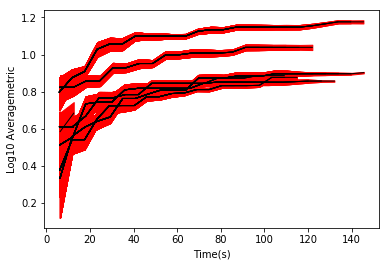

KeyboardInterrupt: 

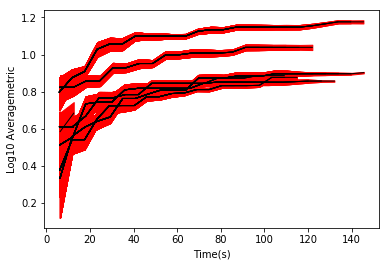

In [22]:
Gene_Matrix_Avg = pickle.load(open(os.path.join(base_path,'Gene_Matrix_Avg_Neuron_SizeNorm.pkl'),'rb'))
Gene_Matrix_std = pickle.load(open(os.path.join(base_path,'Gene_Matrix_std_Neuron_SizeNorm.pkl'),'rb'))
# Gene_Matrix_Avg.columns = ['cell_'+str(i) for i in Gene_Matrix_Avg.columns]
# Gene_Matrix_std.columns = ['cell_'+str(i) for i in Gene_Matrix_std.columns]
Codebook_Class = CodebookClass(Gene_Matrix_Avg,Gene_Matrix_std,base_path=os.path.join(base_path,'Neuron_Results_SizeNorm_1'),
   nbits=6,keepers=10,hamming=2,positive_bits=3,ngenes=50, gene_keepers=50,gene_fold_thresh=1,
   gene_difference_thresh=10,gene_noise=1,gene_offspring_size=3,gene_mutation_rate_info=[30,100,1],
   gene_iterations=100,gene_A=0,gene_verbose=True,substitution_rate=0,swap_rate=0,
   mutation_rate=10,offspring_rate=10,color='r',ncpu=1,iterations=1000,verbose=True,
   fresh=False,filter_genes=False,metric_parameter=-1,gene_metric_parameter=-1,gene_display='metric',display='distance')
Codebook_Class.evolve()

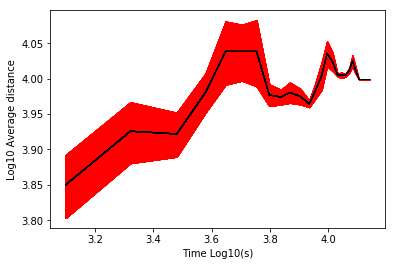

In [71]:
Gene_Matrix_Avg = pickle.load(open(os.path.join(base_path,'Gene_Matrix_Avg_Neuron_SizeNorm.pkl'),'rb'))
Gene_Matrix_std = pickle.load(open(os.path.join(base_path,'Gene_Matrix_std_Neuron_SizeNorm.pkl'),'rb'))
# Gene_Matrix_Avg.columns = ['cell_'+str(i) for i in Gene_Matrix_Avg.columns]
# Gene_Matrix_std.columns = ['cell_'+str(i) for i in Gene_Matrix_std.columns]
Codebook_Class = CodebookClass(Gene_Matrix_Avg,Gene_Matrix_std,base_path=os.path.join(base_path,'Neuron_Results_SizeNorm_3'),
   nbits=6,keepers=10,hamming=2,positive_bits=3,ngenes=100, gene_keepers=10,gene_fold_thresh=1,
   gene_difference_thresh=10,gene_noise=1,gene_offspring_size=3,gene_mutation_rate_info=[30,100,1],
   gene_iterations=200,gene_A=0,gene_verbose=False,substitution_rate=0,swap_rate=0,
   mutation_rate=10,offspring_rate=10,color='r',ncpu=30,iterations=1000,verbose=True,
   fresh=False,filter_genes=False,metric_parameter=-3,gene_metric_parameter=-3,gene_display='metric',display='distance')
Codebook_Class.evolve()

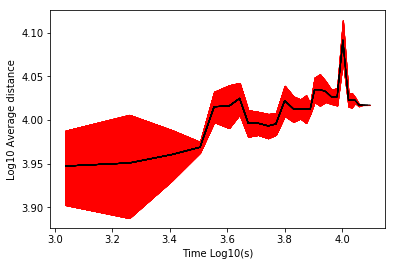

In [72]:
Gene_Matrix_Avg = pickle.load(open(os.path.join(base_path,'Gene_Matrix_Avg_Neuron_SizeNorm.pkl'),'rb'))
Gene_Matrix_std = pickle.load(open(os.path.join(base_path,'Gene_Matrix_std_Neuron_SizeNorm.pkl'),'rb'))
# Gene_Matrix_Avg.columns = ['cell_'+str(i) for i in Gene_Matrix_Avg.columns]
# Gene_Matrix_std.columns = ['cell_'+str(i) for i in Gene_Matrix_std.columns]
Codebook_Class = CodebookClass(Gene_Matrix_Avg,Gene_Matrix_std,base_path=os.path.join(base_path,'Neuron_Results_SizeNorm_3'),
   nbits=6,keepers=10,hamming=2,positive_bits=3,ngenes=100, gene_keepers=10,gene_fold_thresh=1,
   gene_difference_thresh=10,gene_noise=1,gene_offspring_size=3,gene_mutation_rate_info=[30,100,1],
   gene_iterations=200,gene_A=0,gene_verbose=False,substitution_rate=0,swap_rate=0,
   mutation_rate=10,offspring_rate=10,color='r',ncpu=30,iterations=1000,verbose=True,
   fresh=False,filter_genes=False,metric_parameter=-3,gene_metric_parameter=-3,gene_display='metric',display='distance')
Codebook_Class.evolve()

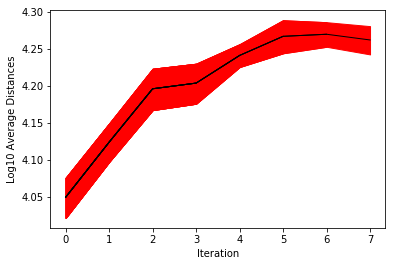

Iteration  8


Process ForkPoolWorker-255:
Process ForkPoolWorker-247:
Process ForkPoolWorker-267:
Process ForkPoolWorker-259:
Process ForkPoolWorker-257:
Process ForkPoolWorker-260:
Process ForkPoolWorker-270:
Process ForkPoolWorker-264:
Process ForkPoolWorker-258:
Process ForkPoolWorker-261:
Process ForkPoolWorker-252:
Process ForkPoolWorker-266:
Process ForkPoolWorker-263:
Process ForkPoolWorker-245:
Process ForkPoolWorker-262:
Process ForkPoolWorker-269:
Process ForkPoolWorker-265:
Process ForkPoolWorker-246:
Process ForkPoolWorker-253:
Process ForkPoolWorker-243:
Process ForkPoolWorker-242:
Process ForkPoolWorker-241:
Process ForkPoolWorker-244:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-254:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (mo

  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "pandas/_libs/index.pyx", line 106, in pandas._libs.index.IndexEngine.get_value
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "<ipython-input-4-b41b2c4a4977>", line 201, in wrapper
    readout,readout_std = self.generate_readout(codebook)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiproce

  File "pandas/_libs/hashtable_class_helper.pxi", line 1492, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "<ipython-input-3-38945fc24cba>", line 189, in selection
    m,d = self.calculate_metric(species)
  File "<ipython-input-4-b41b2c4a4977>", line 125, in generate_readout
    Gene_class.evolve()
  File "<ipython-input-3-38945fc24cba>", line 216, in evolve
    self.selection()
  File "<ipython-input-4-b41b2c4a4977>", line 125, in generate_readout
    Gene_class.evolve()
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "<ipython-input-3-38945fc24cba>", line 216, in evolve
    self.selection()
  File "<ipython-input-4-b41b2c4a4977>", line 201, in wrapper
    readout,readout_std = self.generate_readout(codebook)
KeyboardInterrupt
  File "<ipython-input-3-38945fc24cba>", line 215, in evolve
    self.populate()
  File "<ipython-input-4-b41b2c4a4977>", line 201, in wrapper
  

  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/pandas/core/indexing.py", line 1142, in _getitem_iterable
    indexer = ax.get_indexer_for(key)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/pandas/core/series.py", line 767, in __getitem__
    result = self.index.get_value(self, key)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/pandas/core/indexing.py", line 1901, in _getitem_axis
    return self._getitem_iterable(key, axis=axis)
  File "<ipython-input-3-38945fc24cba>", line 169, in calculate_metric
    neg = np.sum(self.neg_df.loc[species],axis=0)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/pandas/core/indexing.py", line 1478, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/zach/miniconda3/envs/pyspots/lib/p

  File "<ipython-input-4-b41b2c4a4977>", line 201, in wrapper
    readout,readout_std = self.generate_readout(codebook)
KeyboardInterrupt
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/pandas/core/generic.py", line 9593, in stat_func
    numeric_only=numeric_only, min_count=min_count)
  File "pandas/_libs/lib.pyx", line 506, in pandas._libs.lib.clean_index_list
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 3391, in _maybe_promote
    from pandas.core.indexes.datetimes import DatetimeIndex
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/numpy/core/fromnumeric.py", line 75, in _wrapreduction
    reduction = getattr(obj, method)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 3259, in get_indexer
    indexer = self._engine.get_indexer(target._ndarray_values)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-package

  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/pandas/core/indexing.py", line 1901, in _getitem_axis
    return self._getitem_iterable(key, axis=axis)
  File "<frozen importlib._bootstrap>", line 997, in _handle_fromlist
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/pandas/core/indexing.py", line 1142, in _getitem_iterable
    indexer = ax.get_indexer_for(key)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 3385, in get_indexer_for
    return self.get_indexer(target, **kwargs)
KeyboardInterrupt
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 3259, in get_indexer
    indexer = self._engine.get_indexer(target._ndarray_values)
  File "pandas/_libs/index.pyx", line 301, in pandas._libs.index.IndexEngine.get_indexer
  File "pandas/_libs/hashtable_class_helper.pxi", line 1554, in pandas._libs.hashtable.PyObjectHashTable.lookup
  

KeyboardInterrupt: 

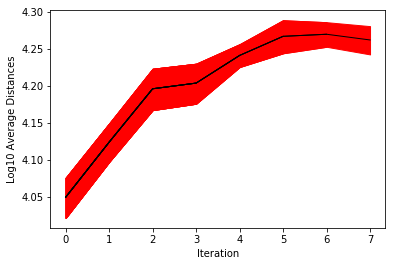

In [5]:
Gene_Matrix_Avg = pickle.load(open(os.path.join(base_path,'Gene_Matrix_Avg_Neuron_SizeNorm.pkl'),'rb'))
Gene_Matrix_std = pickle.load(open(os.path.join(base_path,'Gene_Matrix_std_Neuron_SizeNorm.pkl'),'rb'))
# Gene_Matrix_Avg.columns = ['cell_'+str(i) for i in Gene_Matrix_Avg.columns]
# Gene_Matrix_std.columns = ['cell_'+str(i) for i in Gene_Matrix_std.columns]
Codebook_Class = CodebookClass(Gene_Matrix_Avg,Gene_Matrix_std,base_path=os.path.join(base_path,'Neuron_Results_SizeNorm_1'),
   nbits=6,keepers=10,hamming=2,positive_bits=3,ngenes=50, gene_keepers=10,gene_fold_thresh=1,
   gene_difference_thresh=10,gene_noise=1,gene_offspring_size=10,gene_mutation_rate_info=[30,100,1],
   gene_iterations=30,gene_A=0,gene_verbose=False,substitution_rate=0,swap_rate=0,
   mutation_rate=10,offspring_rate=10,color='r',ncpu=30,iterations=1000,verbose=True,
   fresh=False,filter_genes=False,metric_parameter=-1,gene_metric_parameter=-1)
Codebook_Class.evolve()

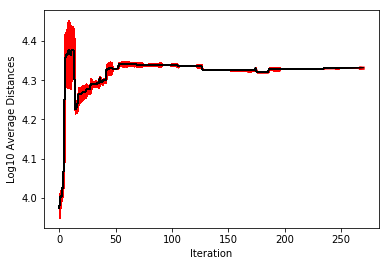

Iteration  271


Process ForkPoolWorker-8151:
Process ForkPoolWorker-8146:
Process ForkPoolWorker-8136:
Process ForkPoolWorker-8134:
Process ForkPoolWorker-8148:
Process ForkPoolWorker-8145:
Process ForkPoolWorker-8154:
Process ForkPoolWorker-8143:
Process ForkPoolWorker-8149:
Process ForkPoolWorker-8137:
Process ForkPoolWorker-8153:
Process ForkPoolWorker-8131:
Process ForkPoolWorker-8157:
Process ForkPoolWorker-8144:
Process ForkPoolWorker-8142:
Process ForkPoolWorker-8132:
Process ForkPoolWorker-8150:
Process ForkPoolWorker-8158:
Process ForkPoolWorker-8159:
Process ForkPoolWorker-8160:
Process ForkPoolWorker-8147:
Process ForkPoolWorker-8155:
Process ForkPoolWorker-8152:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-8135:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-8133:
Traceback (most recent call la

  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/poo

  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/queu

In [ ]:
Gene_Matrix_Avg = pickle.load(open(os.path.join(base_path,'Gene_Matrix_Avg_Neuron_SizeNorm.pkl'),'rb'))
Gene_Matrix_std = pickle.load(open(os.path.join(base_path,'Gene_Matrix_std_Neuron_SizeNorm.pkl'),'rb'))
# Gene_Matrix_Avg.columns = ['cell_'+str(i) for i in Gene_Matrix_Avg.columns]
# Gene_Matrix_std.columns = ['cell_'+str(i) for i in Gene_Matrix_std.columns]
Codebook_Class = CodebookClass(Gene_Matrix_Avg,Gene_Matrix_std,base_path=os.path.join(base_path,'Neuron_Results_SizeNorm_1'),
                               nbits=6,keepers=10,hamming=2,positive_bits=3,ngenes=50, gene_keepers=10,gene_fold_thresh=1,
                               gene_difference_thresh=10,gene_noise=1,gene_offspring_size=10,gene_mutation_rate_info=[30,100,1],
                               gene_iterations=30,gene_A=0,gene_verbose=False,substitution_rate=0,swap_rate=0,
                               mutation_rate=10,offspring_rate=3,color='r',ncpu=30,iterations=1000,verbose=True,
                               fresh=False,filter_genes=False,metric_parameter=-1,gene_metric_parameter=-1)
Codebook_Class.evolve()

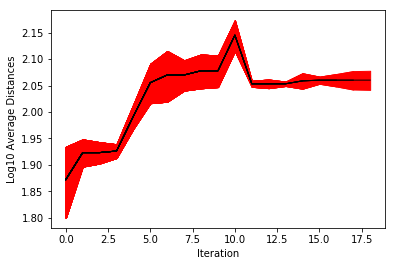

Iteration  19


Process ForkPoolWorker-624:
Process ForkPoolWorker-614:
Process ForkPoolWorker-628:
Process ForkPoolWorker-613:
Process ForkPoolWorker-611:
Process ForkPoolWorker-607:
Process ForkPoolWorker-606:
Process ForkPoolWorker-620:
Process ForkPoolWorker-625:
Process ForkPoolWorker-627:
Process ForkPoolWorker-619:
Process ForkPoolWorker-604:
Process ForkPoolWorker-626:
Process ForkPoolWorker-621:
Process ForkPoolWorker-612:
Process ForkPoolWorker-603:
Process ForkPoolWorker-623:
Process ForkPoolWorker-629:
Process ForkPoolWorker-630:
Process ForkPoolWorker-617:
Process ForkPoolWorker-622:
Process ForkPoolWorker-618:
Process ForkPoolWorker-610:
Process ForkPoolWorker-601:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-615:
Process ForkPoolWorker-608:
Traceback (most recent call last):
Process ForkPoolWorker-605:
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/process.py", line 258, in _boot

  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/zach/miniconda3/envs/pyspots/

  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "<ipython-input-14-38945fc24cba>", line 216, in evolve
    self.selection()
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "<ipython-input-15-9b9deb9840c

  File "pandas/_libs/lib.pyx", line 47, in pandas._libs.lib.values_from_object
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/pandas/core/indexing.py", line 1901, in _getitem_axis
    return self._getitem_iterable(key, axis=axis)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/pandas/core/indexing.py", line 1901, in _getitem_axis
    return self._getitem_iterable(key, axis=axis)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/pandas/core/generic.py", line 9593, in stat_func
    numeric_only=numeric_only, min_count=min_count)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/pandas/core/series.py", line 478, in get_values
    return self._data.get_values()
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/pandas/core/indexes/base.p

In [ ]:
Gene_Matrix_Avg = pickle.load(open(os.path.join(base_path,'Gene_Matrix_Avg_Neuron.pkl'),'rb'))
Gene_Matrix_std = pickle.load(open(os.path.join(base_path,'Gene_Matrix_std_Neuron.pkl'),'rb'))
Gene_Matrix_Avg.columns = ['cell_'+str(i) for i in Gene_Matrix_Avg.columns]
Gene_Matrix_std.columns = ['cell_'+str(i) for i in Gene_Matrix_std.columns]
Codebook_Class = CodebookClass(Gene_Matrix_Avg,Gene_Matrix_std,base_path=os.path.join(base_path,'Neuron_Results_1'),
                               nbits=6,keepers=10,hamming=2,positive_bits=3,ngenes=50, gene_keepers=10,gene_fold_thresh=1,
                               gene_difference_thresh=1,gene_noise=1,gene_offspring_size=10,gene_mutation_rate_info=[30,100,1],
                               gene_iterations=30,gene_A=0,gene_verbose=False,substitution_rate=0,swap_rate=0,
                               mutation_rate=10,offspring_rate=3,color='r',ncpu=30,iterations=100,verbose=True,
                               fresh=False,filter_genes=False,metric_parameter=-1,gene_metric_parameter=-1)
Codebook_Class.evolve()

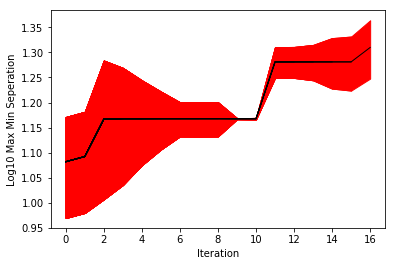

Iteration  17


Process ForkPoolWorker-533:
Process ForkPoolWorker-534:
Process ForkPoolWorker-512:
Process ForkPoolWorker-539:
Process ForkPoolWorker-523:
Process ForkPoolWorker-528:
Process ForkPoolWorker-514:
Process ForkPoolWorker-513:
Process ForkPoolWorker-526:
Process ForkPoolWorker-517:
Process ForkPoolWorker-535:
Process ForkPoolWorker-525:
Process ForkPoolWorker-540:
Process ForkPoolWorker-522:
Process ForkPoolWorker-531:
Process ForkPoolWorker-527:
Process ForkPoolWorker-529:
Process ForkPoolWorker-537:
Process ForkPoolWorker-515:
Process ForkPoolWorker-530:
Process ForkPoolWorker-524:
Process ForkPoolWorker-511:
Process ForkPoolWorker-536:
Process ForkPoolWorker-516:
Process ForkPoolWorker-538:
Process ForkPoolWorker-532:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call

  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/zach/miniconda3/envs/pyspots/lib/p

  File "<ipython-input-3-c59d04d72c32>", line 123, in generate_readout
    Gene_class.evolve()
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "<ipython-input-3-c59d04d72c32>", line 123, in generate_readout
    Gene_class.evolve()
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/zach/miniconda3

  File "pandas/_libs/index.pyx", line 106, in pandas._libs.index.IndexEngine.get_value
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/numpy/core/fromnumeric.py", line 84, in _wrapreduction
    return reduction(axis=axis, out=out, **passkwargs)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/pandas/core/indexing.py", line 1901, in _getitem_axis
    return self._getitem_iterable(key, axis=axis)
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 1579, in is_boolean
    return self.inferred_type in ['boolean']
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/zach/miniconda3/envs/pyspots/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "pandas/_libs/index.pyx", line 114, in pandas._libs.index.IndexEngine.get_value
  File "/home/zach/miniconda3/

In [ ]:
Gene_Matrix_Avg = pickle.load(open(os.path.join(base_path,'Gene_Matrix_Avg_Neuron.pkl'),'rb'))
Gene_Matrix_std = pickle.load(open(os.path.join(base_path,'Gene_Matrix_std_Neuron.pkl'),'rb'))
Gene_Matrix_Avg.columns = ['cell_'+str(i) for i in Gene_Matrix_Avg.columns]
Gene_Matrix_std.columns = ['cell_'+str(i) for i in Gene_Matrix_std.columns]
Codebook_Class = CodebookClass(Gene_Matrix_Avg,Gene_Matrix_std,base_path=os.path.join(base_path,'Neuron_Results_avg'),
                               nbits=6,keepers=10,hamming=2,positive_bits=2,ngenes=50, gene_keepers=10,gene_fold_thresh=1,
                               gene_difference_thresh=1,gene_noise=1,gene_offspring_size=10,gene_mutation_rate_info=[30,100,1],
                               gene_iterations=30,gene_A=0,gene_verbose=False,substitution_rate=0,swap_rate=0,
                               mutation_rate=10,offspring_rate=3,color='r',ncpu=30,iterations=100,verbose=True,
                               fresh=False,filter_genes=False,self.metric_parameter=-1,self.gene_metric_parameter=-1)
Codebook_Class.evolve()

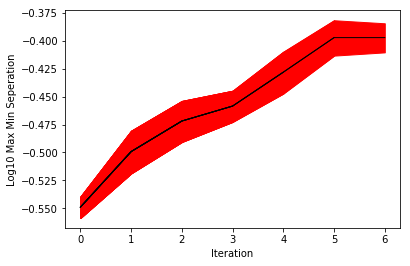

Iteration  7


/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in double_scalars
/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in double_scalars
Process ForkPoolWorker-264:
Process ForkPoolWorker-262:
Process ForkPoolWorker-265:
Process ForkPoolWorker-267:
Process ForkPoolWorker-268:
Process ForkPoolWorker-247:
Process ForkPoolWorker-258:
Process ForkPoolWorker-244:
Process ForkPoolWorker-259:
Process ForkPoolWorker-260:
Process ForkPoolWorker-249:
Process ForkPoolWorker-254:
Process ForkPoolWorker-269:
Process ForkPoolWorker-266:
Process ForkPoolWorker-270:
Process ForkPoolWorker-253:
Process ForkPoolWorker-257:
Process ForkPoolWorker-246:
Process ForkPoolWorker-241:
Process ForkPoolWorker-255:
Process ForkPoolWorker-243:
Process ForkPoolWorker-248:
Process ForkPoolWorker-263:
Process ForkPoolWorker-245:
Process ForkPoolWorker-256:


KeyboardInterrupt: 

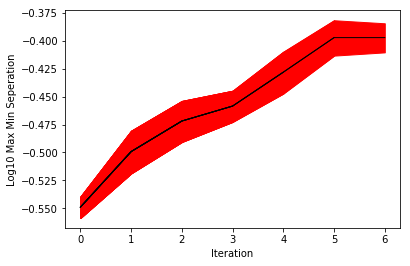

In [5]:
Gene_Matrix_Avg = pickle.load(open(os.path.join(base_path,'Gene_Matrix_Avg_Neuron.pkl'),'rb'))
Gene_Matrix_std = pickle.load(open(os.path.join(base_path,'Gene_Matrix_std_Neuron.pkl'),'rb'))
Gene_Matrix_Avg.columns = ['cell_'+str(i) for i in Gene_Matrix_Avg.columns]
Gene_Matrix_std.columns = ['cell_'+str(i) for i in Gene_Matrix_std.columns]
Codebook_Class = CodebookClass(Gene_Matrix_Avg,Gene_Matrix_std,base_path=os.path.join(base_path,'Neuron_Results4'),nbits=10,keepers=10,hamming=2,positive_bits=3,
                 ngenes=50, gene_keepers=10,gene_fold_thresh=1,gene_difference_thresh=0,gene_noise=1,
                 gene_offspring_size=10,gene_mutation_rate_info=[15,5,0.5],gene_iterations=20,gene_A=0,gene_verbose=False,
                 substitution_rate=0,swap_rate=0,mutation_rate=10,offspring_rate=5,color='r',ncpu=30,iterations=100,verbose=True,fresh=False)
Codebook_Class.evolve()

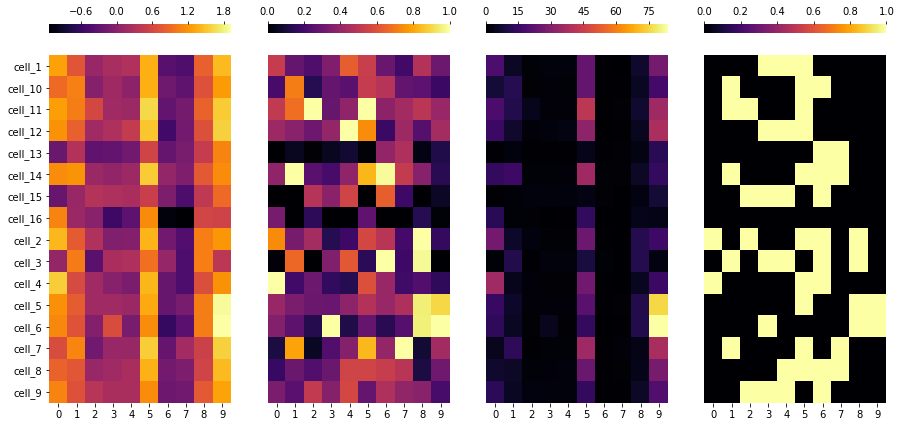

In [17]:
codebook = Codebook_Class.elite_survivor
codebook,readout,readout_std,metric,distance = Codebook_Class.wrapper(codebook)
Readout_df = readout.drop(index='blank')
codebook_df = codebook.drop(index='blank')
norm_Readout_df = Readout_df-np.min(Readout_df,axis=0)
norm_Readout_df = norm_Readout_df/np.max(norm_Readout_df,axis=0)
fig, axes = plt.subplots(ncols=4, figsize=(15, 8))
ax1,ax2,ax3,ax4 = axes
im1 = sns.heatmap(np.log10(Readout_df),cmap='inferno',ax=ax1,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=True)
im2 = sns.heatmap(norm_Readout_df,cmap='inferno',ax=ax2,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
im3 = sns.heatmap(Readout_df,cmap='inferno',ax=ax3,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
im4 = sns.heatmap(codebook_df,cmap='inferno',ax=ax4,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
plt.show()

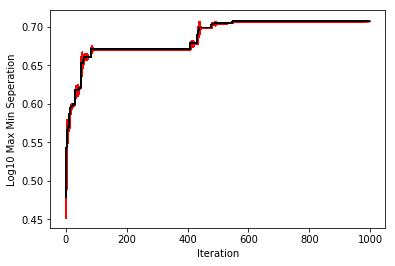

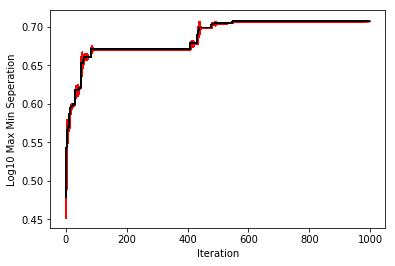

In [16]:
Gene_Matrix_Avg = pickle.load(open(os.path.join(base_path,'Gene_Matrix_Avg.pkl'),'rb'))
Gene_Matrix_std = pickle.load(open(os.path.join(base_path,'Gene_Matrix_std.pkl'),'rb'))
Codebook_Class = CodebookClass(Gene_Matrix_Avg,Gene_Matrix_std,base_path=os.path.join(base_path,'All_Results',nbits=6,keepers=10,hamming=2,positive_bits=3,
                 ngenes=25, gene_keepers=10,gene_fold_thresh=2,gene_difference_thresh=5,gene_noise=1,
                 gene_offspring_size=10,gene_mutation_rate_info=[15,5,0.5],gene_iterations=20,gene_A=0,gene_verbose=False,
                 substitution_rate=3,swap_rate=3,mutation_rate=3,offspring_rate=20,color='r',ncpu=30,iterations=1000,verbose=True,fresh=False)
Codebook_Class.evolve()

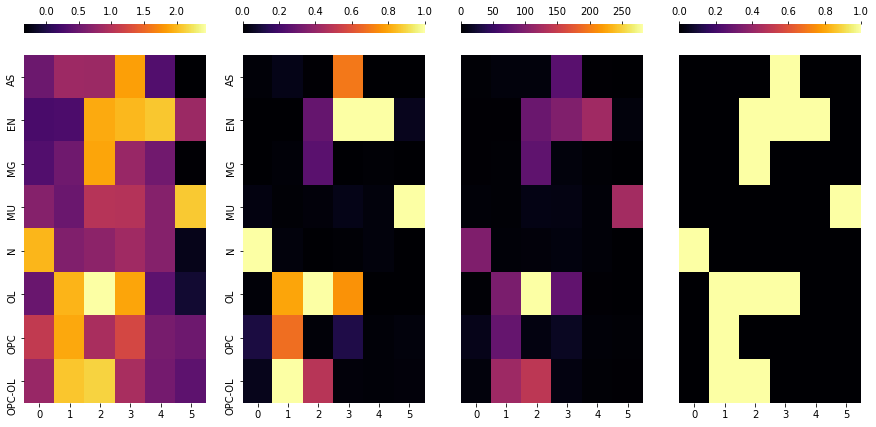

In [19]:
codebook = Codebook_Class.elite_survivor
codebook,readout,readout_std,metric,distance = Codebook_Class.wrapper(codebook)
Readout_df = readout.drop(index='blank')
codebook_df = codebook.drop(index='blank')
norm_Readout_df = Readout_df-np.min(Readout_df,axis=0)
norm_Readout_df = norm_Readout_df/np.max(norm_Readout_df,axis=0)
fig, axes = plt.subplots(ncols=4, figsize=(15, 8))
ax1,ax2,ax3,ax4 = axes
im1 = sns.heatmap(np.log10(Readout_df),cmap='inferno',ax=ax1,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=True)
im2 = sns.heatmap(norm_Readout_df,cmap='inferno',ax=ax2,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=True)
im3 = sns.heatmap(Readout_df,cmap='inferno',ax=ax3,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
im4 = sns.heatmap(codebook_df,cmap='inferno',ax=ax4,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
plt.show()

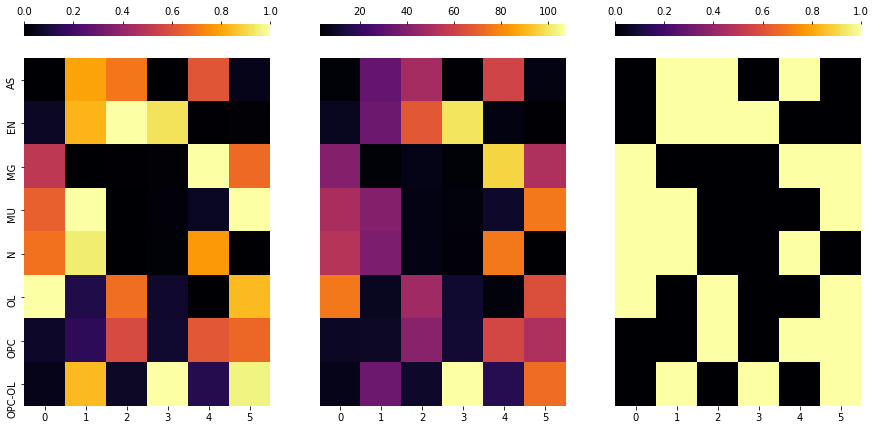

In [132]:
Readout_df = readout.drop(index='blank')
codebook_df = codebook.drop(index='blank')
norm_Readout_df = Readout_df-np.min(Readout_df,axis=0)
norm_Readout_df = norm_Readout_df/np.max(norm_Readout_df,axis=0)
fig, axes = plt.subplots(ncols=3, figsize=(15, 8))
ax2,ax3,ax4 = axes
# im1 = sns.heatmap(np.log10(Readout_df/np.average(Readout_df,axis=0)),cmap='bwr',center=0,ax=ax1,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=True)
im2 = sns.heatmap(norm_Readout_df,cmap='inferno',ax=ax2,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=True)
im3 = sns.heatmap(Readout_df,cmap='inferno',ax=ax3,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
im4 = sns.heatmap(codebook_df,cmap='inferno',ax=ax4,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
plt.show()

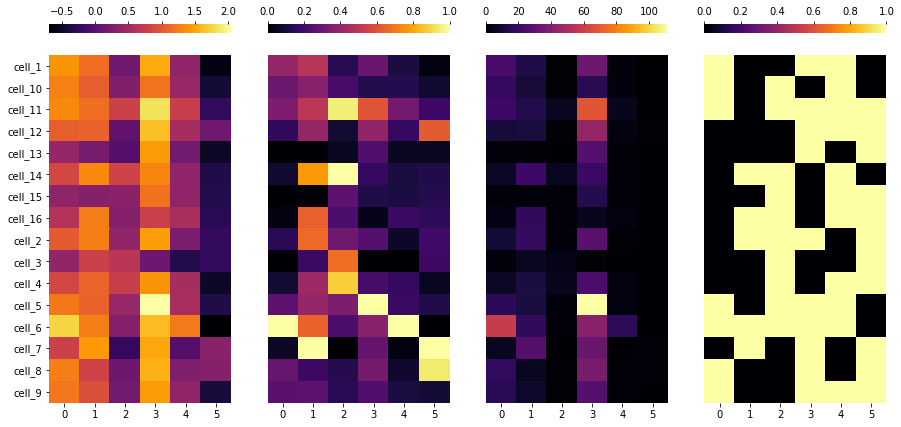

In [71]:
codebook = Codebook_Class.elite_survivor
codebook,readout,readout_std,metric,distance = Codebook_Class.wrapper(codebook)
Readout_df = readout.drop(index='blank')
codebook_df = codebook.drop(index='blank')
norm_Readout_df = Readout_df-np.min(Readout_df,axis=0)
norm_Readout_df = norm_Readout_df/np.max(norm_Readout_df,axis=0)
fig, axes = plt.subplots(ncols=4, figsize=(15, 8))
ax1,ax2,ax3,ax4 = axes
im1 = sns.heatmap(np.log10(Readout_df),cmap='inferno',ax=ax1,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=True)
im2 = sns.heatmap(norm_Readout_df,cmap='inferno',ax=ax2,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
im3 = sns.heatmap(Readout_df,cmap='inferno',ax=ax3,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
im4 = sns.heatmap(codebook_df,cmap='inferno',ax=ax4,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
plt.show()

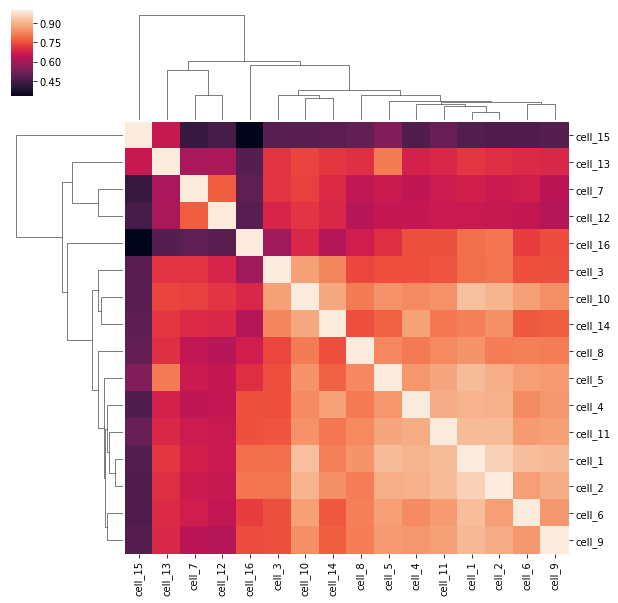

In [63]:
cells = list(Gene_Matrix_Avg.drop(columns='blank').columns)
matrix = np.ones([len(cells),len(cells)])
for x,c1 in enumerate(cells):
    for y,c2 in enumerate(cells):
        if x<y:
            dist = spearmanr(Gene_Matrix_Avg[c1],Gene_Matrix_Avg[c2])[0]
            matrix[x,y] = dist
            matrix[y,x] = dist
similarity = pd.DataFrame(matrix,index=cells,columns=cells)
sns.clustermap(similarity)
plt.show()

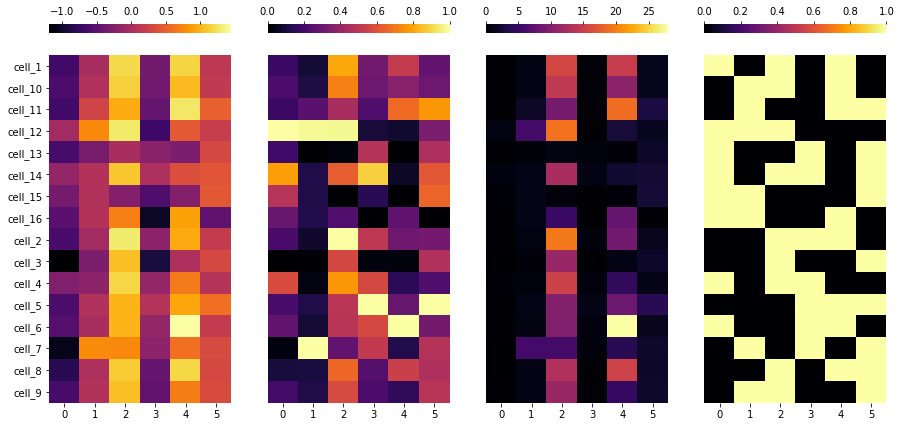

In [66]:
codebook = Codebook_Class.elite_survivor
codebook,readout,readout_std,metric,distance = Codebook_Class.wrapper(codebook)
Readout_df = readout.drop(index='blank')
codebook_df = codebook.drop(index='blank')
norm_Readout_df = Readout_df-np.min(Readout_df,axis=0)
norm_Readout_df = norm_Readout_df/np.max(norm_Readout_df,axis=0)
fig, axes = plt.subplots(ncols=4, figsize=(15, 8))
ax1,ax2,ax3,ax4 = axes
im1 = sns.heatmap(np.log10(Readout_df),cmap='inferno',ax=ax1,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=True)
im2 = sns.heatmap(norm_Readout_df,cmap='inferno',ax=ax2,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
im3 = sns.heatmap(Readout_df,cmap='inferno',ax=ax3,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
im4 = sns.heatmap(codebook_df,cmap='inferno',ax=ax4,cbar_kws = dict(use_gridspec=False,location="top"),yticklabels=False)
plt.show()

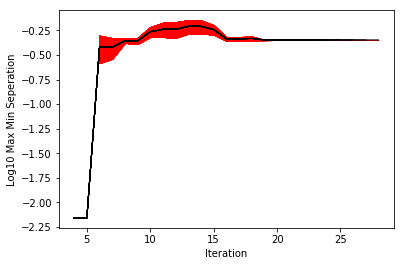

KeyboardInterrupt: 

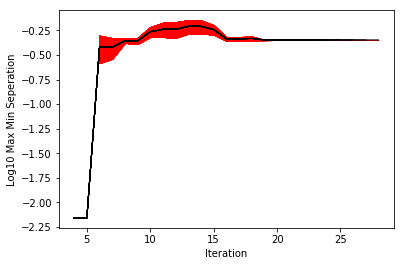

In [67]:
codebook = Codebook_Class.elite_survivor
self = Codebook_Class
bit=1
pos_cells = list(codebook[codebook[bit]==1].index)
print(pos_cells)
neg_cells = list(codebook[codebook[bit]==0].index)
Gene_class = GeneClass(self.Gene_Matrix_Avg,self.Gene_Matrix_std,pos_cells,neg_cells=neg_cells,
                       ngenes=self.ngenes,keepers=self.gene_keepers,fold_thresh=1,
                       difference_thresh=0,noise=self.gene_noise,offspring_size=self.gene_offspring_size,
                       mutation_rate_info=self.gene_mutation_rate_info,iterations=100,
                       color=self.color,A=self.gene_A,verbose=True)

Gene_class.evolve()

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


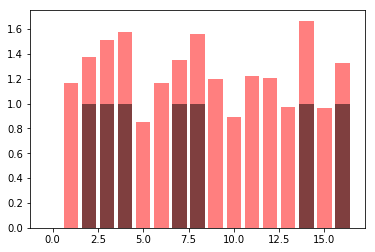

In [69]:
Y1 = list(np.log10(np.sum(Gene_class.Gene_Matrix_Avg.loc[Gene_class.survivors[0]],axis=0))+1)
Y2 = list(codebook[bit])
plt.bar(range(len(Y1)),Y1,color='r',alpha=0.5)
plt.bar(range(len(Y2)),Y2,color='k',alpha=0.5)
plt.show()

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


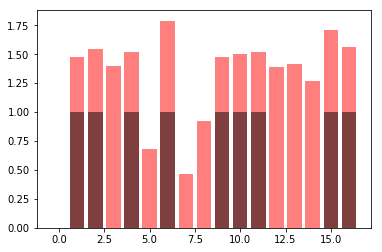

In [52]:
Y1 = list(np.log10(np.sum(Gene_class.Gene_Matrix_Avg.loc[Gene_class.survivors[0]],axis=0))+1)
Y2 = list(codebook[bit])
plt.bar(range(len(Y1)),Y1,color='r',alpha=0.5)
plt.bar(range(len(Y2)),Y2,color='k',alpha=0.5)
plt.show()